In [3]:
import pydicom 
import os      
import csv     
import logging

In [4]:
# Configurar el registro básico para ver mensajes informativos o errores
logging.basicConfig(level=logging.INFO, format='%(levelname)s: %(message)s')

# --- Configuración ---
# !!! IMPORTANTE: Reemplaza esto con la ruta REAL a tu directorio data_1 !!!
data_dir = './Tarea_1/datos/data_1'
output_csv_file = 'patient_info_data1.csv'
# --- Fin de Configuración ---

# Lista para almacenar la información de los pacientes
patient_data = []

# Verificar si el directorio data_1 existe
if not os.path.isdir(data_dir):
    logging.error(f"El directorio especificado no existe: {data_dir}")
    # Puedes detener la ejecución aquí si lo prefieres
    # exit()
else:
    logging.info(f"Buscando archivos DICOM en: {data_dir}")
    # Iterar sobre todos los archivos en el directorio especificado
    for filename in os.listdir(data_dir):
        # Construir la ruta completa al elemento
        filepath = os.path.join(data_dir, filename)

        # Verificar si es un archivo (y no un subdirectorio)
        if os.path.isfile(filepath):
            try:
                # Intentar leer el archivo como DICOM
                ds = pydicom.dcmread(filepath, force=True) # force=True puede ayudar con algunos problemas de preámbulo

                # Extraer el nombre del paciente y la fecha de nacimiento
                # Usamos .get() para evitar errores si la etiqueta no existe
                patient_name = ds.get('PatientName', 'N/A')
                birth_date = ds.get('PatientBirthDate', 'N/A')

                # Asegurarse de que el nombre del paciente se maneje correctamente (puede ser un objeto PersonName)
                if isinstance(patient_name, pydicom.valuerep.PersonName):
                    patient_name = str(patient_name) # Convertir a cadena

                # Añadir los datos a nuestra lista
                patient_data.append([patient_name, birth_date])
                logging.info(f"Procesado: {filename} - Nombre: {patient_name}, Nacimiento: {birth_date}")

            except pydicom.errors.InvalidDicomError:
                # Si el archivo no es un DICOM válido, registrar un aviso
                logging.warning(f"Archivo no es DICOM o está corrupto, omitiendo: {filename}")
            except Exception as e:
                # Capturar otros posibles errores durante la lectura o extracción
                logging.error(f"Error procesando el archivo {filename}: {e}")

# Escribir los datos recopilados en un archivo CSV
if patient_data: # Solo escribir si se encontraron datos
    try:
        with open(output_csv_file, 'w', newline='', encoding='utf-8') as csvfile:
            writer = csv.writer(csvfile)
            # Escribir la cabecera
            writer.writerow(['PatientName', 'PatientBirthDate'])
            # Escribir los datos de los pacientes
            writer.writerows(patient_data)
        logging.info(f"Archivo CSV '{output_csv_file}' generado exitosamente con {len(patient_data)} registros.")
    except Exception as e:
        logging.error(f"Error al escribir el archivo CSV: {e}")
else:
    logging.warning("No se encontraron datos de pacientes para escribir en el archivo CSV.")


INFO: Buscando archivos DICOM en: ./Tarea_1/datos/data_1
INFO: Procesado: 019787df3ae203ec160fb86dbee9275b.dcm - Nombre: Débora Salas, Nacimiento: 19770508
INFO: Procesado: 121969a3ea1dcd63ea14b7c8754098d3.dcm - Nombre: Luis Chabert, Nacimiento: 19830208
INFO: Procesado: 16e2678d2ea8d8638f69a6f7b54eb030.dcm - Nombre: Alejandro Chabert, Nacimiento: 19791001
INFO: Procesado: 22b3866a120110dde0ed9bfd73088e93.dcm - Nombre: Cesar Buendía, Nacimiento: 19830729
INFO: Procesado: 24cdd17911455e15811b3a330d625ce9.dcm - Nombre: Germán Roncagliolo, Nacimiento: 19770513
INFO: Procesado: 3d5a32fc7bc51b8c88ad46cce0354520.dcm - Nombre: Pablo Roncagliolo, Nacimiento: 19830202
INFO: Procesado: 50cda0fb366c8e4b30766b3a435c3a40.dcm - Nombre: Germán Salas, Nacimiento: 19850204
INFO: Procesado: 53494c16c19ddf12a01ee4affd2a3181.dcm - Nombre: Pablo Buendía, Nacimiento: 19850915
INFO: Procesado: 5b5a722e6da741943f0f761ec4b4d7ec.dcm - Nombre: Wael Veloz, Nacimiento: 19770720
INFO: Procesado: 6b9959c342ad8cc56e4

INFO: Buscando archivos DICOM en: ./Tarea_1/datos/data_1
INFO: Procesando 20 archivos encontrados...
INFO: Mostrando 20 imágenes DICOM...


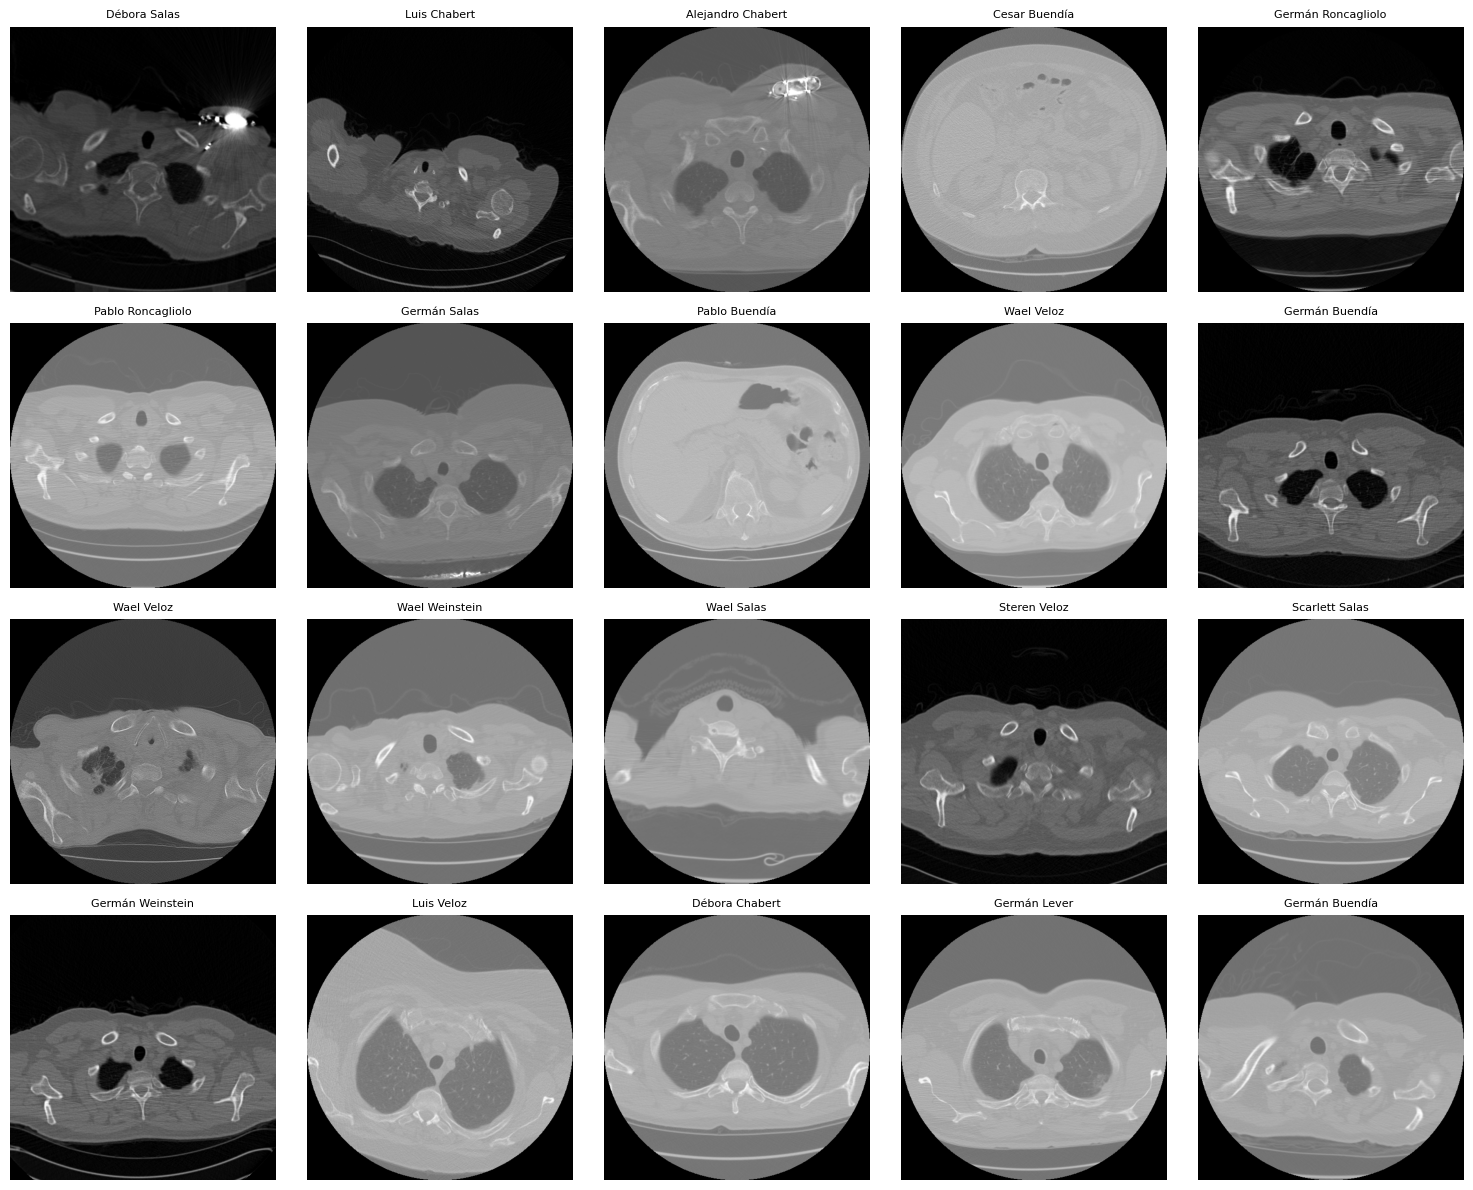

In [3]:
# Importar las bibliotecas necesarias
import os
import pydicom
import numpy as np
import matplotlib.pyplot as plt
import math # Para calcular la cuadrícula de subplots
import logging

# Configurar el registro básico
logging.basicConfig(level=logging.INFO, format='%(levelname)s: %(message)s')

dicom_files = []

# Verificar si el directorio data_1 existe
if not os.path.isdir(data_dir):
    logging.error(f"El directorio especificado no existe o no es un directorio: {data_dir}")
    logging.error("Por favor, verifica la ruta en la variable 'data_dir' en el script.")
else:
    logging.info(f"Buscando archivos DICOM en: {data_dir}")
    # Recopilar rutas de archivos que parecen ser DICOM
    for filename in os.listdir(data_dir):
        filepath = os.path.join(data_dir, filename)
        if os.path.isfile(filepath):
            # Una verificación rápida podría ser la extensión, aunque no es infalible
            # if filename.lower().endswith('.dcm'):
            #     dicom_files.append(filepath)
            # O simplemente intentar leer todos y manejar errores después
            dicom_files.append(filepath) # Añadimos todos los archivos por ahora

# Filtrar la lista para intentar leer solo los que son DICOM válidos y tienen imagen
valid_datasets = []
patient_names = []

logging.info(f"Procesando {len(dicom_files)} archivos encontrados...")
for filepath in dicom_files:
    try:
        ds = pydicom.dcmread(filepath) # Ahora necesitamos leer los píxeles

        # Verificar si el archivo tiene datos de píxeles
        if 'PixelData' in ds:
            # Extraer nombre del paciente
            patient_name_tag = ds.get('PatientName', 'Nombre Desconocido')
            if isinstance(patient_name_tag, pydicom.valuerep.PersonName):
                 patient_name = str(patient_name_tag)
            else:
                 patient_name = str(patient_name_tag)

            valid_datasets.append(ds)
            patient_names.append(patient_name)
            # logging.info(f"Archivo válido agregado: {os.path.basename(filepath)}")
        else:
            logging.warning(f"Archivo omitido (sin PixelData): {os.path.basename(filepath)}")

    except pydicom.errors.InvalidDicomError:
        logging.warning(f"Archivo no es DICOM válido, omitiendo: {os.path.basename(filepath)}")
    except Exception as e:
        logging.error(f"Error leyendo {os.path.basename(filepath)}: {e}")

# Proceder solo si se encontraron imágenes válidas
if not valid_datasets:
    logging.error("No se encontraron archivos DICOM válidos con imágenes para mostrar.")
else:
    logging.info(f"Mostrando {len(valid_datasets)} imágenes DICOM...")

    # Calcular dimensiones de la cuadrícula de subplots
    num_images = len(valid_datasets)
    # Queremos una cuadrícula lo más cuadrada posible
    cols = math.ceil(math.sqrt(num_images))
    rows = math.ceil(num_images / cols)

    # Crear la figura y los ejes (subplots)
    # figsize ajusta el tamaño total de la figura
    fig, axes = plt.subplots(rows, cols, figsize=(cols * 3, rows * 3)) # Ajusta el tamaño por subplot

    # Aplanar el array de ejes si es multidimensional, para iterar fácilmente
    axes = axes.ravel()

    # Iterar sobre los datasets DICOM válidos y mostrarlos
    for i, ds in enumerate(valid_datasets):
        # Mostrar la imagen
        # Usamos cmap=plt.cm.gray para asegurar que se muestre en escala de grises
        axes[i].imshow(ds.pixel_array, cmap=plt.cm.gray)
        # Poner el nombre del paciente como título
        axes[i].set_title(patient_names[i], fontsize=8) # Ajustar tamaño de fuente si es necesario
        # Ocultar los ejes (ticks y etiquetas numéricas)
        axes[i].axis('off')

    # Ocultar los ejes sobrantes si la cuadrícula no es perfecta
    for j in range(num_images, len(axes)):
        axes[j].axis('off')

    # Ajustar el espaciado entre subplots para evitar superposiciones
    plt.tight_layout()
    # Mostrar la figura
    plt.show()

In [4]:
# Importar las bibliotecas necesarias
import os
import pydicom
import logging

# Configurar el registro básico
logging.basicConfig(level=logging.INFO, format='%(levelname)s: %(message)s')


# --- Configuración ---
input_dir = './Tarea_1/datos/data_1' # Reemplaza con la ruta a tu directorio de entrada

# !!! IMPORTANTE: Define una carpeta NUEVA donde guardar los archivos anonimizados !!!
# Puede ser una subcarpeta o una ruta completamente diferente.
output_dir = './Tarea_1/datos/data_1_anonimizada' # Ejemplo
# --- Fin de Configuración ---

# Etiquetas DICOM comunes a anonimizar (puedes añadir o quitar según necesidad)
# Formato: (Grupo, Elemento) o Nombre de la Palabra Clave (Keyword)
tags_to_anonymize = [
    'PatientName',        # (0010,0010)
    'PatientID',          # (0010,0020)
    'PatientBirthDate',   # (0010,0030)
    'PatientSex',         # (0010,0040) - Opcional, a veces se conserva
    'PatientAddress',     # (0010,1040) - Si existe
    'PatientTelephoneNumbers', # (0010,2154) - Si existe
    'ReferringPhysicianName', # (0008,0090) - Si existe
    'InstitutionName',    # (0008,0080) - Si existe
    'OperatorsName',      # (0008,1070) - Si existe
    # Añade aquí otras etiquetas si es necesario, por ejemplo:
    # 'OtherPatientIDs', (0010,1000)
    # (0010, 1001) OtherPatientNames
    # (0010, 1010) PatientAge
    # (0010, 1060) PatientMotherBirthName
    # (0010, 2160) EthnicGroup
    # (0010, 4000) PatientComments
    # (0008, 0050) AccessionNumber
    # (0008, 1030) StudyDescription
    # (0008, 103E) SeriesDescription
    # (0008, 1040) InstitutionalDepartmentName
    # (0008, 1050) PerformingPhysicianName
    # (0008, 1060) NameOfPhysiciansReadingStudy
    # (0020, 000D) StudyInstanceUID - ¡Cuidado! Cambiar UIDs puede romper referencias
    # (0020, 000E) SeriesInstanceUID - ¡Cuidado!
    # (0008, 0018) SOPInstanceUID - ¡Cuidado!
]

# Función para anonimizar un dataset DICOM
def anonymize_dicom_dataset(ds):
    """Modifica o elimina etiquetas sensibles en un dataset pydicom."""
    logging.debug("Iniciando anonimización del dataset...")
    for tag_key in tags_to_anonymize:
        if tag_key in ds:
            try:
                # Opción 1: Borrar la etiqueta completamente
                # del ds[tag_key]
                # logging.debug(f"Eliminando etiqueta: {tag_key}")

                # Opción 2: Reemplazar por un valor vacío o genérico
                # Obtener el elemento de datos para saber su VR (Value Representation)
                data_element = ds.data_element(tag_key)
                if data_element:
                    # Asignar cadena vacía si es tipo string-like (LO, SH, PN, CS, etc.)
                    # Asignar cadena vacía para fechas/horas (DA, TM, DT)
                    # Para UIDs, es más complejo, usualmente no se borran o se generan nuevos.
                    # Para números (IS, DS), poner 0 o '' podría ser problemático,
                    # mejor borrar o manejar específicamente.
                    if data_element.VR in ['LO', 'SH', 'PN', 'CS', 'AS', 'AE', 'LT', 'ST', 'UT', 'DA', 'TM', 'DT']:
                         ds[tag_key].value = '' # Asignar vacío
                         logging.debug(f"Vaciando etiqueta: {tag_key}")
                    elif data_element.VR in ['UI']:
                         # Por ahora no modificamos UIDs para evitar romper referencias
                         logging.debug(f"Omitiendo UID por seguridad: {tag_key}")
                         pass
                    else:
                         # Para otros tipos (ej. numéricos, secuencias), borrar es más seguro
                         logging.debug(f"Eliminando etiqueta (tipo {data_element.VR}): {tag_key}")
                         del ds[tag_key]
                else:
                    # Si no podemos obtener el elemento (raro si tag_key está en ds), borrar
                    logging.debug(f"Eliminando etiqueta (elemento no obtenido): {tag_key}")
                    del ds[tag_key]

            except KeyError:
                 # Si intentamos borrar una etiqueta que ya no existe (poco probable aquí)
                 logging.warning(f"Etiqueta {tag_key} no encontrada para eliminar/modificar.")
            except Exception as e:
                 logging.error(f"Error procesando etiqueta {tag_key}: {e}")

    # Opcional: Añadir una etiqueta indicando que el archivo fue modificado/anonimizado
    ds.add_new((0x0012, 0x0062), 'CS', 'YES')  # PatientIdentityRemoved
    ds.add_new((0x0012, 0x0063), 'LO', 'Anonimizado por script Tarea1') # DeidentificationMethod
    logging.debug("Anonimización del dataset completada.")
    return ds

# --- Inicio del Script ---

# Verificar si el directorio de entrada existe
if not os.path.isdir(input_dir):
    logging.error(f"El directorio de entrada especificado no existe: {input_dir}")
    # exit()
else:
    # Crear el directorio de salida si no existe
    try:
        os.makedirs(output_dir, exist_ok=True) # exist_ok=True evita error si ya existe
        logging.info(f"Directorio de salida: {output_dir}")
    except OSError as e:
        logging.error(f"No se pudo crear el directorio de salida {output_dir}: {e}")
        # exit()

    logging.info(f"Buscando archivos DICOM en: {input_dir}")
    # Iterar sobre los archivos en el directorio de entrada
    file_count = 0
    success_count = 0
    for filename in os.listdir(input_dir):
        input_filepath = os.path.join(input_dir, filename)
        output_filepath = os.path.join(output_dir, filename) # Mismo nombre, diferente carpeta

        if os.path.isfile(input_filepath):
            file_count += 1
            logging.debug(f"Procesando archivo: {filename}")
            try:
                # Leer el archivo DICOM original (completo)
                ds = pydicom.dcmread(input_filepath)

                # Anonimizar el dataset
                ds_anon = anonymize_dicom_dataset(ds)

                # Guardar el dataset anonimizado en la carpeta de salida
                # ds_anon.save_as(output_filepath) # Alternativa
                pydicom.dcmwrite(output_filepath, ds_anon, write_like_original=True)
                logging.info(f"Archivo anonimizado guardado: {output_filepath}")
                success_count += 1

            except pydicom.errors.InvalidDicomError:
                logging.warning(f"Archivo no es DICOM válido, omitiendo: {filename}")
            except Exception as e:
                logging.error(f"Error procesando o guardando {filename}: {e}")

    logging.info(f"Proceso completado. {success_count} de {file_count} archivos procesados y guardados en {output_dir}")

INFO: Directorio de salida: ./Tarea_1/datos/data_1_anonimizada
INFO: Buscando archivos DICOM en: ./Tarea_1/datos/data_1
INFO: Archivo anonimizado guardado: ./Tarea_1/datos/data_1_anonimizada\019787df3ae203ec160fb86dbee9275b.dcm
INFO: Archivo anonimizado guardado: ./Tarea_1/datos/data_1_anonimizada\121969a3ea1dcd63ea14b7c8754098d3.dcm


INFO: Archivo anonimizado guardado: ./Tarea_1/datos/data_1_anonimizada\16e2678d2ea8d8638f69a6f7b54eb030.dcm
INFO: Archivo anonimizado guardado: ./Tarea_1/datos/data_1_anonimizada\22b3866a120110dde0ed9bfd73088e93.dcm
INFO: Archivo anonimizado guardado: ./Tarea_1/datos/data_1_anonimizada\24cdd17911455e15811b3a330d625ce9.dcm
INFO: Archivo anonimizado guardado: ./Tarea_1/datos/data_1_anonimizada\3d5a32fc7bc51b8c88ad46cce0354520.dcm
INFO: Archivo anonimizado guardado: ./Tarea_1/datos/data_1_anonimizada\50cda0fb366c8e4b30766b3a435c3a40.dcm
INFO: Archivo anonimizado guardado: ./Tarea_1/datos/data_1_anonimizada\53494c16c19ddf12a01ee4affd2a3181.dcm
INFO: Archivo anonimizado guardado: ./Tarea_1/datos/data_1_anonimizada\5b5a722e6da741943f0f761ec4b4d7ec.dcm
INFO: Archivo anonimizado guardado: ./Tarea_1/datos/data_1_anonimizada\6b9959c342ad8cc56e42e2e3905424d4.dcm
INFO: Archivo anonimizado guardado: ./Tarea_1/datos/data_1_anonimizada\6c1e91d0076333f589467bfc3e6172e8.dcm
INFO: Archivo anonimizado gu

In [5]:
# Configurar el registro básico para ver mensajes informativos o errores
logging.basicConfig(level=logging.INFO, format='%(levelname)s: %(message)s')

# --- Configuración ---
# !!! IMPORTANTE: Reemplaza esto con la ruta REAL a tu directorio data_1 !!!
data_dir = './Tarea_1/datos/data_1_anonimizada'
output_csv_file = 'patient_info_data1_anonimizada.csv'
# --- Fin de Configuración ---

# Lista para almacenar la información de los pacientes
patient_data = []

# Verificar si el directorio data_1 existe
if not os.path.isdir(data_dir):
    logging.error(f"El directorio especificado no existe: {data_dir}")
    # Puedes detener la ejecución aquí si lo prefieres
    # exit()
else:
    logging.info(f"Buscando archivos DICOM en: {data_dir}")
    # Iterar sobre todos los archivos en el directorio especificado
    for filename in os.listdir(data_dir):
        # Construir la ruta completa al elemento
        filepath = os.path.join(data_dir, filename)

        # Verificar si es un archivo (y no un subdirectorio)
        if os.path.isfile(filepath):
            try:
                # Intentar leer el archivo como DICOM
                ds = pydicom.dcmread(filepath, force=True) # force=True puede ayudar con algunos problemas de preámbulo

                # Extraer el nombre del paciente y la fecha de nacimiento
                # Usamos .get() para evitar errores si la etiqueta no existe
                patient_name = ds.get('PatientName', 'N/A')
                birth_date = ds.get('PatientBirthDate', 'N/A')

                # Asegurarse de que el nombre del paciente se maneje correctamente (puede ser un objeto PersonName)
                if isinstance(patient_name, pydicom.valuerep.PersonName):
                    patient_name = str(patient_name) # Convertir a cadena

                # Añadir los datos a nuestra lista
                patient_data.append([patient_name, birth_date])
                logging.info(f"Procesado: {filename} - Nombre: {patient_name}, Nacimiento: {birth_date}")

            except pydicom.errors.InvalidDicomError:
                # Si el archivo no es un DICOM válido, registrar un aviso
                logging.warning(f"Archivo no es DICOM o está corrupto, omitiendo: {filename}")
            except Exception as e:
                # Capturar otros posibles errores durante la lectura o extracción
                logging.error(f"Error procesando el archivo {filename}: {e}")

# Escribir los datos recopilados en un archivo CSV
if patient_data: # Solo escribir si se encontraron datos
    try:
        with open(output_csv_file, 'w', newline='', encoding='utf-8') as csvfile:
            writer = csv.writer(csvfile)
            # Escribir la cabecera
            writer.writerow(['PatientName', 'PatientBirthDate'])
            # Escribir los datos de los pacientes
            writer.writerows(patient_data)
        logging.info(f"Archivo CSV '{output_csv_file}' generado exitosamente con {len(patient_data)} registros.")
    except Exception as e:
        logging.error(f"Error al escribir el archivo CSV: {e}")
else:
    logging.warning("No se encontraron datos de pacientes para escribir en el archivo CSV.")


INFO: Buscando archivos DICOM en: ./Tarea_1/datos/data_1_anonimizada
INFO: Procesado: 019787df3ae203ec160fb86dbee9275b.dcm - Nombre: , Nacimiento: 
INFO: Procesado: 121969a3ea1dcd63ea14b7c8754098d3.dcm - Nombre: , Nacimiento: 
INFO: Procesado: 16e2678d2ea8d8638f69a6f7b54eb030.dcm - Nombre: , Nacimiento: 
INFO: Procesado: 22b3866a120110dde0ed9bfd73088e93.dcm - Nombre: , Nacimiento: 
INFO: Procesado: 24cdd17911455e15811b3a330d625ce9.dcm - Nombre: , Nacimiento: 
INFO: Procesado: 3d5a32fc7bc51b8c88ad46cce0354520.dcm - Nombre: , Nacimiento: 
INFO: Procesado: 50cda0fb366c8e4b30766b3a435c3a40.dcm - Nombre: , Nacimiento: 
INFO: Procesado: 53494c16c19ddf12a01ee4affd2a3181.dcm - Nombre: , Nacimiento: 
INFO: Procesado: 5b5a722e6da741943f0f761ec4b4d7ec.dcm - Nombre: , Nacimiento: 
INFO: Procesado: 6b9959c342ad8cc56e42e2e3905424d4.dcm - Nombre: , Nacimiento: 
INFO: Procesado: 6c1e91d0076333f589467bfc3e6172e8.dcm - Nombre: , Nacimiento: 
INFO: Procesado: 7510e0ae9b42ae60be15409c64cb0144.dcm - Nombre

INFO: Buscando y leyendo archivos DICOM en: ./Tarea_1/datos/data_2
INFO: Se leyeron 110 cortes DICOM.
INFO: Cortes ordenados por SliceLocation.
INFO: Construyendo el volumen 3D...
INFO: Volumen 3D construido con dimensiones: (110, 512, 512)


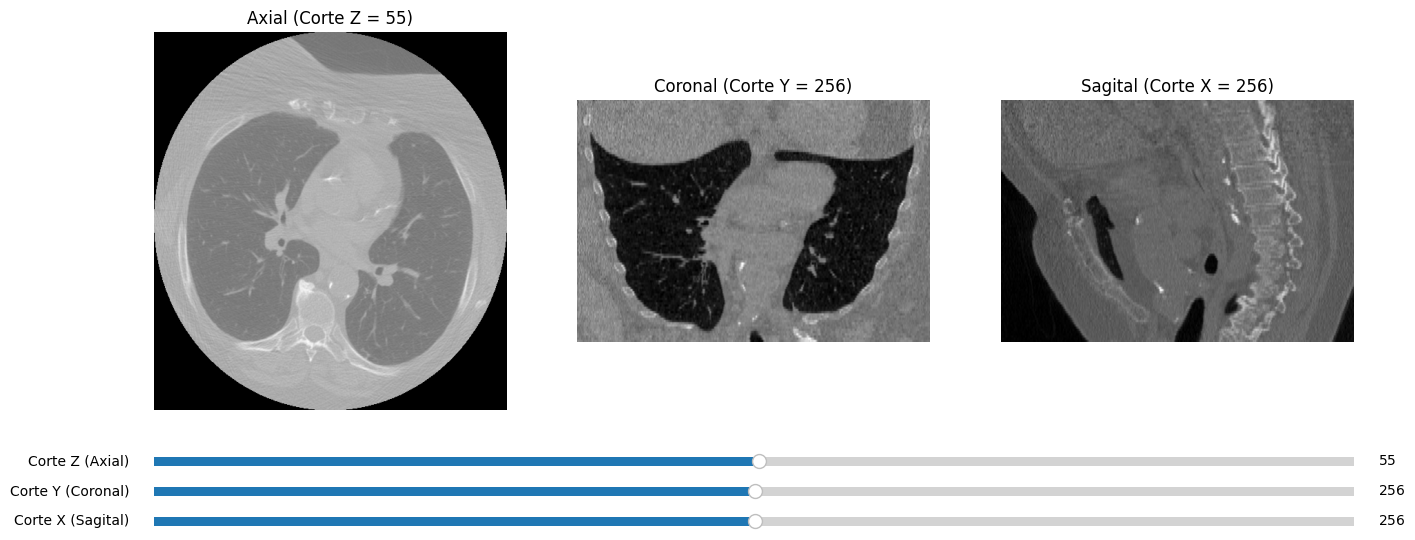

In [6]:
# Importar las bibliotecas necesarias
import os
import pydicom
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.widgets import Slider # Importar el widget Slider
import logging

# Configurar el registro básico
logging.basicConfig(level=logging.INFO, format='%(levelname)s: %(message)s')

# --- Configuración ---
# !!! IMPORTANTE: Reemplaza esto con la ruta REAL a tu directorio data_2 !!!
data_dir = './Tarea_1/datos/data_2'
# --- Fin de Configuración ---

# Lista para guardar los datasets leídos
slices = []

# Verificar si el directorio data_2 existe
if not os.path.isdir(data_dir):
    logging.error(f"El directorio especificado no existe o no es un directorio: {data_dir}")
    # exit()
else:
    logging.info(f"Buscando y leyendo archivos DICOM en: {data_dir}")
    # Leer todos los archivos DICOM en el directorio
    for filename in os.listdir(data_dir):
        filepath = os.path.join(data_dir, filename)
        if os.path.isfile(filepath):
            try:
                ds = pydicom.dcmread(filepath)
                if 'PixelData' in ds and ('SliceLocation' in ds or 'ImagePositionPatient' in ds):
                    slices.append(ds)
                else:
                    logging.warning(f"Archivo omitido (sin PixelData o etiqueta de posición): {filename}")
            except pydicom.errors.InvalidDicomError:
                logging.warning(f"Archivo no es DICOM válido, omitiendo: {filename}")
            except Exception as e:
                logging.error(f"Error leyendo {filename}: {e}")

# Verificar si se leyeron cortes
if not slices:
    logging.error("No se encontraron cortes DICOM válidos en el directorio especificado.")
    # exit()
else:
    logging.info(f"Se leyeron {len(slices)} cortes DICOM.")

    # Ordenar los cortes
    try:
        if hasattr(slices[0], 'SliceLocation'):
            slices.sort(key=lambda x: float(x.SliceLocation))
            logging.info("Cortes ordenados por SliceLocation.")
        elif hasattr(slices[0], 'ImagePositionPatient'):
            slices.sort(key=lambda x: float(x.ImagePositionPatient[2]))
            logging.info("Cortes ordenados por ImagePositionPatient[2] (coordenada Z).")
        else:
            logging.warning("No se encontró etiqueta para ordenar los cortes. El volumen puede ser incorrecto.")
    except Exception as e:
        logging.error(f"Error al intentar ordenar los cortes: {e}. El volumen puede ser incorrecto.")

    # --- Construcción del Volumen 3D ---
    logging.info("Construyendo el volumen 3D...")
    shape = slices[0].pixel_array.shape
    volume_ok = True
    for ds in slices[1:]:
        if ds.pixel_array.shape != shape:
            logging.error(f"Las dimensiones del corte {ds.filename} no coinciden. No se puede construir el volumen.")
            volume_ok = False
            break

    if volume_ok:
        try:
            volume_3d = np.stack([s.pixel_array for s in slices], axis=0)
            logging.info(f"Volumen 3D construido con dimensiones: {volume_3d.shape}")

            # Obtener dimensiones (Z, Y, X) o (slices, rows, cols)
            num_slices, rows, cols = volume_3d.shape

            # --- Configuración de la Figura Interactiva ---
            fig, axes = plt.subplots(1, 3, figsize=(15, 6)) # Un poco más de espacio vertical
            # Ajustar el espacio para dejar sitio a los sliders
            plt.subplots_adjust(left=0.1, bottom=0.25)

            # Calcular aspect ratios (una sola vez)
            pixel_spacing = slices[0].get('PixelSpacing', [1, 1])
            slice_thickness = slices[0].get('SliceThickness', pixel_spacing[0])
            aspect_coronal = slice_thickness / pixel_spacing[1] # Z / X
            aspect_sagittal = slice_thickness / pixel_spacing[0] # Z / Y

            # Índices iniciales (centrales)
            initial_z = num_slices // 2
            initial_y = rows // 2
            initial_x = cols // 2

            # Mostrar las imágenes iniciales y guardar las referencias a los objetos de imagen
            im_axial = axes[0].imshow(volume_3d[initial_z, :, :], cmap=plt.cm.gray, aspect='auto')
            im_coronal = axes[1].imshow(volume_3d[:, initial_y, :], cmap=plt.cm.gray, aspect=aspect_coronal)
            im_sagittal = axes[2].imshow(volume_3d[:, :, initial_x], cmap=plt.cm.gray, aspect=aspect_sagittal)

            # Poner títulos iniciales
            axes[0].set_title(f'Axial (Corte Z = {initial_z})')
            axes[1].set_title(f'Coronal (Corte Y = {initial_y})')
            axes[2].set_title(f'Sagital (Corte X = {initial_x})')

            # Ocultar ejes numéricos
            for ax in axes:
                ax.axis('off')

            # --- Crear los Sliders ---
            # Definir las posiciones de los sliders [left, bottom, width, height]
            ax_slider_z = plt.axes([0.1, 0.15, 0.8, 0.03]) # Slider para eje Z (Axial)
            ax_slider_y = plt.axes([0.1, 0.1, 0.8, 0.03])  # Slider para eje Y (Coronal)
            ax_slider_x = plt.axes([0.1, 0.05, 0.8, 0.03]) # Slider para eje X (Sagital)

            # Crear los objetos Slider
            slider_z = Slider(ax=ax_slider_z, label='Corte Z (Axial)',
                              valmin=0, valmax=num_slices - 1, valinit=initial_z, valstep=1)
            slider_y = Slider(ax=ax_slider_y, label='Corte Y (Coronal)',
                              valmin=0, valmax=rows - 1, valinit=initial_y, valstep=1)
            slider_x = Slider(ax=ax_slider_x, label='Corte X (Sagital)',
                              valmin=0, valmax=cols - 1, valinit=initial_x, valstep=1)

            # --- Función de Actualización ---
            def update(val):
                # Obtener los valores actuales de los sliders (como enteros)
                current_z = int(slider_z.val)
                current_y = int(slider_y.val)
                current_x = int(slider_x.val)

                # Actualizar los datos de las imágenes
                im_axial.set_data(volume_3d[current_z, :, :])
                im_coronal.set_data(volume_3d[:, current_y, :])
                im_sagittal.set_data(volume_3d[:, :, current_x])

                # Actualizar los títulos
                axes[0].set_title(f'Axial (Corte Z = {current_z})')
                axes[1].set_title(f'Coronal (Corte Y = {current_y})')
                axes[2].set_title(f'Sagital (Corte X = {current_x})')

                # Volver a dibujar la figura para mostrar los cambios
                fig.canvas.draw_idle()

            # --- Conectar los Sliders a la Función de Actualización ---
            slider_z.on_changed(update)
            slider_y.on_changed(update)
            slider_x.on_changed(update)

            # Mostrar la figura interactiva
            plt.show()

        except Exception as e:
             logging.error(f"Error durante la construcción del volumen o la visualización interactiva: {e}")

In [7]:
# Importar las bibliotecas necesarias
import os
import pydicom
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import map_coordinates # Para la interpolación/mapeo
import logging

# Configurar el registro básico
logging.basicConfig(level=logging.INFO, format='%(levelname)s: %(message)s')

# --- Configuración ---
# !!! IMPORTANTE: Reemplaza esto con la ruta REAL a tu directorio data_2 !!!
data_dir = './Tarea_1/datos/data_2'
# --- Fin de Configuración ---

# Lista para guardar los datasets leídos
slices = []

# --- (Inicio: Código para leer y ordenar los cortes - Igual que antes) ---
if not os.path.isdir(data_dir):
    logging.error(f"El directorio especificado no existe: {data_dir}")
    # exit()
else:
    logging.info(f"Buscando y leyendo archivos DICOM en: {data_dir}")
    for filename in os.listdir(data_dir):
        filepath = os.path.join(data_dir, filename)
        if os.path.isfile(filepath):
            try:
                ds = pydicom.dcmread(filepath)
                if 'PixelData' in ds and ('SliceLocation' in ds or 'ImagePositionPatient' in ds):
                    slices.append(ds)
                else:
                    logging.warning(f"Omitido (sin PixelData o pos): {filename}")
            except pydicom.errors.InvalidDicomError:
                logging.warning(f"No es DICOM válido: {filename}")
            except Exception as e:
                logging.error(f"Error leyendo {filename}: {e}")

if not slices:
    logging.error("No se encontraron cortes DICOM válidos.")
    # exit()
else:
    logging.info(f"Se leyeron {len(slices)} cortes.")
    try:
        if hasattr(slices[0], 'SliceLocation'):
            slices.sort(key=lambda x: float(x.SliceLocation))
            logging.info("Cortes ordenados por SliceLocation.")
        elif hasattr(slices[0], 'ImagePositionPatient'):
            slices.sort(key=lambda x: float(x.ImagePositionPatient[2]))
            logging.info("Cortes ordenados por ImagePositionPatient[2].")
        else:
            logging.warning("No se encontró etiqueta para ordenar.")
    except Exception as e:
        logging.error(f"Error al ordenar: {e}")
# --- (Fin: Código para leer y ordenar los cortes) ---


    # --- (Inicio: Construcción del Volumen 3D - Igual que antes) ---
    logging.info("Construyendo el volumen 3D...")
    shape = slices[0].pixel_array.shape
    volume_ok = True
    for ds in slices[1:]:
        if ds.pixel_array.shape != shape:
            logging.error("Dimensiones de cortes no coinciden.")
            volume_ok = False
            break

    if volume_ok:
        try:
            volume_3d = np.stack([s.pixel_array for s in slices], axis=0)
            num_slices, rows, cols = volume_3d.shape
            logging.info(f"Volumen 3D construido: {volume_3d.shape}")
    # --- (Fin: Construcción del Volumen 3D) ---


            # --- Extracción del Corte Oblicuo ---
            logging.info("Calculando corte oblicuo...")

            # 1. Definir el plano oblicuo:
            #    Necesitamos un punto central y dos vectores directores ortogonales
            #    en el espacio 3D (Z, Y, X) que definan el plano.

            #    Ejemplo: Plano a 45 grados entre Coronal y Sagital, pasando por el centro.
            center_z = num_slices / 2.0
            center_y = rows / 2.0
            center_x = cols / 2.0
            center_point = np.array([center_z, center_y, center_x])

            #    Vector 1: a lo largo del eje Z (dirección original de los cortes)
            vec1 = np.array([1.0, 0.0, 0.0])
            #    Vector 2: a 45 grados entre Y y X en el plano XY
            angle = np.deg2rad(45) # Ángulo de 45 grados
            vec2 = np.array([0.0, np.cos(angle), np.sin(angle)])

            #    Asegurarse de que sean ortogonales (aunque en este caso lo son por construcción)
            #    vec1 = vec1 / np.linalg.norm(vec1) # Normalizar
            #    vec2 = vec2 / np.linalg.norm(vec2) # Normalizar

            # 2. Crear una rejilla (grid) de puntos en el plano oblicuo 2D
            #    Definimos el tamaño de la imagen oblicua (ej. similar al tamaño sagital/coronal)
            slice_height = num_slices # Usamos Z como altura
            slice_width = int(np.sqrt(rows**2 + cols**2)) # Ancho diagonal aproximado

            #    Creamos coordenadas 2D (xi, yi) para la nueva imagen oblicua
            xi, yi = np.meshgrid(np.arange(slice_width), np.arange(slice_height), indexing='ij')

            # 3. Mapear las coordenadas 2D (xi, yi) del plano oblicuo a coordenadas 3D (z, y, x)
            #    del volumen original. La fórmula general es:
            #    Coords3D = Centro + (xi - ancho/2)*VectorDirector1 + (yi - alto/2)*VectorDirector2
            #    Adaptamos para que las coordenadas xi, yi se mapeen correctamente
            #    Nota: El sistema de coordenadas de map_coordinates es (z, y, x)

            coords_3d = center_point[:, np.newaxis, np.newaxis] + \
                        vec1[:, np.newaxis, np.newaxis] * (yi - slice_height / 2.0) + \
                        vec2[:, np.newaxis, np.newaxis] * (xi - slice_width / 2.0)

            # coords_3d tendrá forma (3, slice_width, slice_height)
            # La primera dimensión corresponde a Z, Y, X

            # 4. Interpolar los valores del volumen en las coordenadas 3D calculadas
            #    map_coordinates espera las coordenadas como (dimension, ...coords...)
            #    El 'order=1' significa interpolación bilineal (rápida), 'order=3' es cúbica (más suave)
            oblique_slice = map_coordinates(volume_3d, coords_3d, order=1, mode='nearest')

            logging.info(f"Corte oblicuo generado con dimensiones: {oblique_slice.shape}")


            # --- Visualización del Corte Oblicuo ---
            plt.figure(figsize=(8, 8))
            plt.imshow(oblique_slice.T, cmap=plt.cm.gray, origin='lower') # Transponer y ajustar origen si es necesario
            plt.title(f'Corte Oblicuo (Ej: 45° Coronal-Sagital)')
            plt.xlabel('Eje oblicuo X\'')
            plt.ylabel('Eje oblicuo Y\'')
            plt.colorbar(label='Intensidad')
            plt.axis('on') # Mantener ejes para ver coordenadas
            plt.show()


        except NameError as ne:
             # Capturar si volume_3d no se definió por error previo
             logging.error(f"No se pudo completar porque falta el volumen 3D: {ne}")
        except Exception as e:
             logging.error(f"Error durante la generación o visualización del corte oblicuo: {e}")

KeyboardInterrupt: 

INFO: Procesando archivo: ./Tarea_1/datos/p5.dcm
INFO: Imagen original leída con dimensiones: (512, 512)
INFO: Imagen reducida generada con dimensiones: (128, 128)


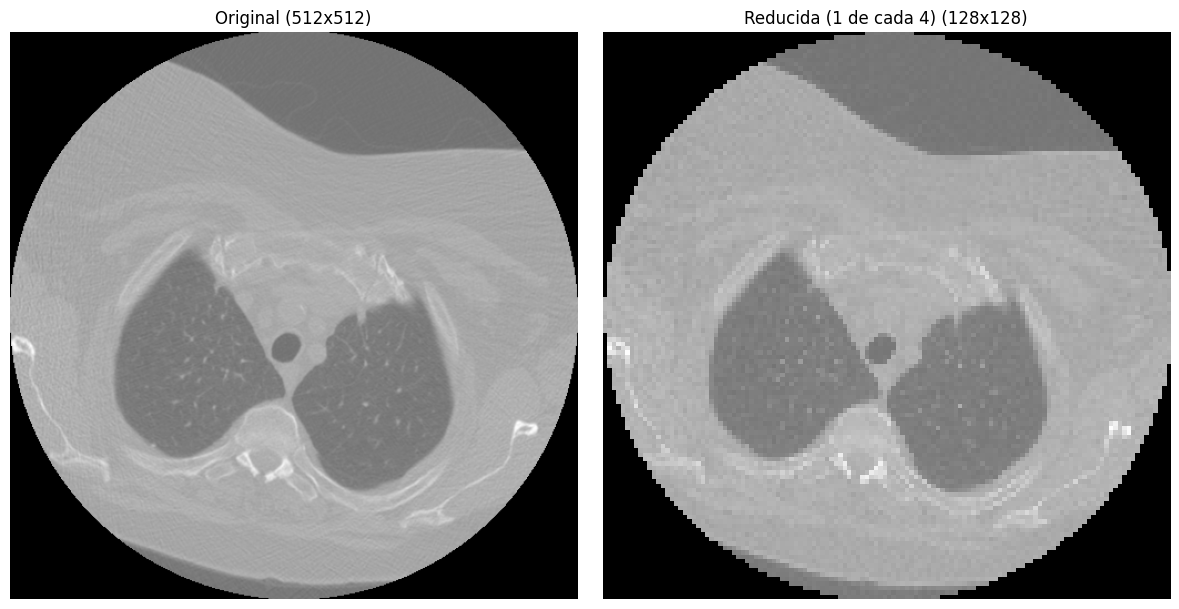


Comentarios sobre las diferencias:
Observa las dos imágenes mostradas arriba y compara:
- Claridad y detalle: ¿Cómo afecta la reducción de píxeles a la visibilidad de las estructuras finas?
- Tamaño: La reducción de tamaño es evidente.
- Posibles artefactos: ¿Aparecen patrones extraños o bordes 'escalonados' (aliasing) en la imagen reducida?
- Información perdida: ¿Qué información crees que se pierde irreversiblemente con este tipo de downsampling?

(Escribe tus comentarios detallados en tu informe .ipynb)


In [ ]:
# Importar las bibliotecas necesarias
import os
import pydicom
import numpy as np
import matplotlib.pyplot as plt
import logging

# Configurar el registro básico
logging.basicConfig(level=logging.INFO, format='%(levelname)s: %(message)s')

# --- Configuración ---
# !!! IMPORTANTE: Reemplaza esto con la ruta COMPLETA al archivo p5.dcm !!!
# Puede estar en data_1 o data_2, o en otra ubicación si lo moviste.
# Ejemplo: p5_filepath = 'ruta/a/tu/directorio/data_1/p5.dcm'
p5_filepath = './Tarea_1/datos/p5.dcm'

# Factor de downsampling (conservar 1 de cada 'n' píxeles)
downsample_factor = 4
# --- Fin de Configuración ---

# Verificar si el archivo existe
if not os.path.isfile(p5_filepath):
    logging.error(f"El archivo especificado no existe: {p5_filepath}")
    logging.error("Por favor, verifica la ruta en la variable 'p5_filepath'.")
else:
    logging.info(f"Procesando archivo: {p5_filepath}")
    try:
        # Leer el archivo DICOM
        ds = pydicom.dcmread(p5_filepath)

        # Verificar que tenga datos de imagen
        if 'PixelData' not in ds:
            logging.error("El archivo DICOM no contiene datos de imagen (PixelData).")
        else:
            # Obtener la imagen original como un array de NumPy
            original_image = ds.pixel_array
            original_shape = original_image.shape
            logging.info(f"Imagen original leída con dimensiones: {original_shape}")

            # Verificar que la imagen sea 2D
            if original_image.ndim != 2:
                logging.error(f"Se esperaba una imagen 2D, pero tiene {original_image.ndim} dimensiones.")
            # Verificar el tamaño esperado (opcional, basado en la descripción [cite: 23])
            elif original_shape != (512, 512):
                 logging.warning(f"La imagen tiene dimensiones {original_shape}, pero se esperaba (512, 512).")

            # --- Realizar el Downsampling ---
            # Usar slicing de NumPy: array[start:stop:step]
            # ::n significa tomar elementos desde el principio hasta el final, con un paso de 'n'
            downsampled_image = original_image[::downsample_factor, ::downsample_factor]
            downsampled_shape = downsampled_image.shape
            logging.info(f"Imagen reducida generada con dimensiones: {downsampled_shape}")

            # --- Visualización ---
            fig, axes = plt.subplots(1, 2, figsize=(12, 6))

            # Mostrar imagen original
            axes[0].imshow(original_image, cmap=plt.cm.gray)
            axes[0].set_title(f'Original ({original_shape[0]}x{original_shape[1]})')
            axes[0].axis('off')

            # Mostrar imagen reducida
            axes[1].imshow(downsampled_image, cmap=plt.cm.gray)
            axes[1].set_title(f'Reducida (1 de cada {downsample_factor}) ({downsampled_shape[0]}x{downsampled_shape[1]})')
            axes[1].axis('off')

            plt.tight_layout()
            plt.show()

            # --- Comentarios ---
            print("\n" + "="*30)
            print("Comentarios sobre las diferencias:")
            print("="*30)
            print("Observa las dos imágenes mostradas arriba y compara:")
            print("- Claridad y detalle: ¿Cómo afecta la reducción de píxeles a la visibilidad de las estructuras finas?")
            print("- Tamaño: La reducción de tamaño es evidente.")
            print("- Posibles artefactos: ¿Aparecen patrones extraños o bordes 'escalonados' (aliasing) en la imagen reducida?")
            print("- Información perdida: ¿Qué información crees que se pierde irreversiblemente con este tipo de downsampling?")
            print("\n(Escribe tus comentarios detallados en tu informe .ipynb)")


    except pydicom.errors.InvalidDicomError:
        logging.error(f"El archivo no es un DICOM válido: {p5_filepath}")
    except Exception as e:
        logging.error(f"Ocurrió un error inesperado: {e}")

INFO: Buscando y leyendo archivos DICOM en: ./Tarea_1/datos/data_2
INFO: Se leyeron 110 cortes DICOM potencialmente válidos.
INFO: Cortes ordenados usando SliceLocation.
INFO: Intentando construir el volumen 3D...
INFO: Volumen 3D construido exitosamente con dimensiones: (110, 512, 512)
INFO: Volumen 3D construido: (110, 512, 512)


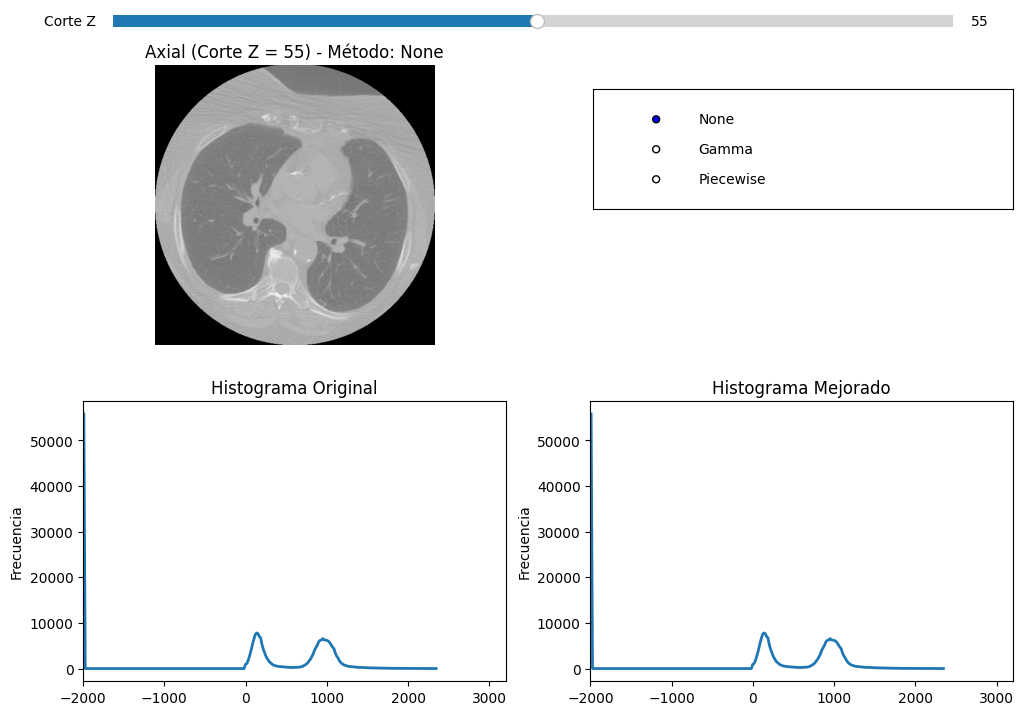


Comentarios sobre la Mejora de Contraste:
Experimenta con los controles (Gamma, Piecewise Linear) y observa:
- ¿Cómo afecta el parámetro gamma al brillo y contraste general?
- ¿Para qué tipo de imágenes (oscuras, brillantes, bajo contraste) es útil cada método?
- ¿Cómo se relaciona la forma de la función de transformación (implícita en Piecewise, explícita en Gamma) con la forma del histograma resultante?
- ¿Cuándo la 'mejora' de contraste podría hacer que se pierdan detalles o se introduzcan artefactos?

(Escribe tus comentarios detallados en tu informe .ipynb)


In [ ]:
# Importar las bibliotecas necesarias
import os
import pydicom
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.widgets import Slider, RadioButtons # Importar widgets
import logging
# Ignorar advertencias comunes de división por cero o valores inválidos en logs, etc.
np.seterr(divide='ignore', invalid='ignore')

# Configurar el registro básico
logging.basicConfig(level=logging.INFO, format='%(levelname)s: %(message)s')

# --- Configuración ---
# !!! IMPORTANTE: Reemplaza esto con la ruta REAL a tu directorio data_2 !!!
data_dir = './Tarea_1/datos/data_2'
# --- Fin de Configuración ---

# --- Funciones de Mejora de Contraste ---

def normalize_image(img):
    """Normaliza la imagen al rango [0, 1] para procesamiento."""
    min_val = np.min(img)
    max_val = np.max(img)
    if max_val > min_val:
        return (img.astype(np.float32) - min_val) / (max_val - min_val)
    else:
        # Evitar división por cero si la imagen es constante
        return np.zeros_like(img, dtype=np.float32)

def denormalize_image(img_norm, original_min, original_max):
    """Devuelve la imagen normalizada a su rango original."""
    if original_max > original_min:
        return (img_norm * (original_max - original_min)) + original_min
    else:
        # Si el rango original era cero, devolver una imagen constante
        return np.full_like(img_norm, original_min)

def gamma_correction(img, gamma, c=1.0):
    """Aplica la corrección gamma: s = c * r^gamma."""
    # Guardar rango original
    min_val, max_val = np.min(img), np.max(img)
    # Normalizar
    img_norm = normalize_image(img)
    # Aplicar gamma (asegurándose de que gamma no sea cero o negativo)
    gamma_safe = max(gamma, 0.01) # Evitar gamma <= 0
    img_corrected_norm = c * (img_norm ** gamma_safe)
    # Recortar a [0, 1] en caso de que c > 1
    img_corrected_norm = np.clip(img_corrected_norm, 0, 1)
    # Devolver al rango original
    return denormalize_image(img_corrected_norm, min_val, max_val)

def piecewise_linear(img, r1, s1, r2, s2):
    """Aplica transformación lineal por tramos (3 segmentos)."""
    # Guardar rango original y normalizar los puntos de control r1, r2
    min_val, max_val = np.min(img), np.max(img)
    if max_val <= min_val: # Imagen constante, no hacer nada
        return img.copy()

    r1_norm = (r1 - min_val) / (max_val - min_val)
    r2_norm = (r2 - min_val) / (max_val - min_val)
    s1_norm = s1 # Asumimos que s1, s2 ya están en [0, 1]
    s2_norm = s2 # Asumimos que s1, s2 ya están en [0, 1]

    # Asegurarse de que r1 < r2 y s1, s2 estén en [0, 1]
    r1_norm = np.clip(r1_norm, 0, 1)
    r2_norm = np.clip(r2_norm, 0, 1)
    s1_norm = np.clip(s1_norm, 0, 1)
    s2_norm = np.clip(s2_norm, 0, 1)
    if r1_norm >= r2_norm: # Evitar puntos inválidos
        r1_norm = 0.4
        r2_norm = 0.6

    img_norm = normalize_image(img)
    img_transformed_norm = np.zeros_like(img_norm)

    # Tramo 1: [0, r1] -> [0, s1]
    mask1 = img_norm < r1_norm
    if r1_norm > 0: # Evitar división por cero
      slope1 = s1_norm / r1_norm
      img_transformed_norm[mask1] = slope1 * img_norm[mask1]
    else: # Si r1 es 0, todos estos píxeles van a s1 (o 0 si s1 es 0)
      img_transformed_norm[mask1] = s1_norm if s1_norm > 0 else 0

    # Tramo 2: [r1, r2] -> [s1, s2]
    mask2 = (img_norm >= r1_norm) & (img_norm <= r2_norm)
    if r2_norm > r1_norm: # Evitar división por cero
        slope2 = (s2_norm - s1_norm) / (r2_norm - r1_norm)
        img_transformed_norm[mask2] = s1_norm + slope2 * (img_norm[mask2] - r1_norm)
    else: # Si r1=r2, los píxeles en r1 van a s1 (o (s1+s2)/2 ?)
        img_transformed_norm[mask2] = s1_norm

    # Tramo 3: [r2, 1] -> [s2, 1]
    mask3 = img_norm > r2_norm
    if 1 > r2_norm: # Evitar división por cero
      slope3 = (1 - s2_norm) / (1 - r2_norm)
      img_transformed_norm[mask3] = s2_norm + slope3 * (img_norm[mask3] - r2_norm)
    else: # Si r2 es 1, todos estos píxeles van a s2 (o 1 si s2 es 1)
       img_transformed_norm[mask3] = 1.0 if s2_norm >= 1.0 else s2_norm

    # Devolver al rango original
    return denormalize_image(img_transformed_norm, min_val, max_val)

# --- Inicio: Código para leer y ordenar los cortes ---
slices = [] # Lista para guardar los datasets leídos

# Verificar si el directorio data_2 existe
if not os.path.isdir(data_dir):
    logging.error(f"El directorio especificado no existe o no es un directorio: {data_dir}")
    # Considera detener la ejecución si el directorio no existe
    # exit()
else:
    logging.info(f"Buscando y leyendo archivos DICOM en: {data_dir}")
    # Leer todos los archivos DICOM en el directorio
    for filename in os.listdir(data_dir):
        filepath = os.path.join(data_dir, filename)
        if os.path.isfile(filepath): # Asegurarse de que es un archivo
            try:
                # Leer el archivo DICOM
                ds = pydicom.dcmread(filepath)
                # Verificar que tenga datos de imagen y alguna etiqueta de posición para ordenar
                if 'PixelData' in ds and ('SliceLocation' in ds or 'ImagePositionPatient' in ds):
                    slices.append(ds) # Añadir el dataset a la lista
                else:
                    # Registrar si falta PixelData o etiqueta de posición
                    missing_tags = []
                    if 'PixelData' not in ds: missing_tags.append('PixelData')
                    if 'SliceLocation' not in ds and 'ImagePositionPatient' not in ds:
                        missing_tags.append('SliceLocation/ImagePositionPatient')
                    logging.warning(f"Archivo omitido '{filename}' (faltan etiquetas: {', '.join(missing_tags)})")
            except pydicom.errors.InvalidDicomError:
                # Registrar si el archivo no parece ser DICOM
                logging.warning(f"Archivo no es DICOM válido, omitiendo: {filename}")
            except Exception as e:
                # Registrar cualquier otro error durante la lectura
                logging.error(f"Error leyendo el archivo {filename}: {e}")

# Verificar si se leyeron cortes válidos
if not slices:
    logging.error("No se encontraron cortes DICOM válidos con información de posición en el directorio especificado.")
    # Considera detener la ejecución si no hay slices
    # exit()
else:
    logging.info(f"Se leyeron {len(slices)} cortes DICOM potencialmente válidos.")

    # Ordenar los cortes --- ¡MUY IMPORTANTE! ---
    # Intentar ordenar por SliceLocation primero, si no, por la componente Z de ImagePositionPatient
    sorted_correctly = False
    try:
        first_slice = slices[0] # Tomar el primer slice para verificar qué etiqueta usar
        if hasattr(first_slice, 'SliceLocation'):
            # Ordenar usando SliceLocation como número flotante
            slices.sort(key=lambda x: float(x.SliceLocation))
            logging.info("Cortes ordenados usando SliceLocation.")
            sorted_correctly = True
        elif hasattr(first_slice, 'ImagePositionPatient'):
            # Ordenar usando la tercera componente (Z) de ImagePositionPatient
            slices.sort(key=lambda x: float(x.ImagePositionPatient[2]))
            logging.info("Cortes ordenados usando ImagePositionPatient[2] (coordenada Z).")
            sorted_correctly = True
        else:
            # Si no hay etiqueta de ordenamiento conocida en el primer slice (y asumimos que es igual para todos)
            logging.warning("No se encontró SliceLocation ni ImagePositionPatient en el primer corte para ordenar. El volumen puede ser incorrecto.")
            # Podríamos intentar ordenar por nombre de archivo como último recurso, pero es poco fiable:
            # slices.sort(key=lambda x: x.filename)
            # logging.warning("Intentando ordenar por nombre de archivo (puede ser incorrecto).")

    except Exception as e:
        # Registrar cualquier error durante el proceso de ordenamiento
        logging.error(f"Error al intentar ordenar los cortes: {e}. El volumen puede ser incorrecto.")

    # --- Fin: Código para leer y ordenar los cortes ---


    # --- Inicio: Construcción del Volumen 3D ---
    volume_3d = None # Inicializar volume_3d como None
    logging.info("Intentando construir el volumen 3D...")

    # Verificar que todas las imágenes tengan el mismo tamaño (importante)
    try:
        first_shape = slices[0].pixel_array.shape
        if not all(s.pixel_array.shape == first_shape for s in slices):
             logging.error("Las dimensiones de los cortes DICOM no coinciden. No se puede construir el volumen.")
        else:
             # Apilar los arrays 2D en un único array 3D de NumPy
             # La forma será (num_slices, rows, cols)
             volume_3d = np.stack([s.pixel_array for s in slices], axis=0)
             logging.info(f"Volumen 3D construido exitosamente con dimensiones: {volume_3d.shape}")

    except AttributeError:
         logging.error("Error accediendo a pixel_array. Asegúrate de que los archivos DICOM contienen imágenes.")
    except Exception as e:
         logging.error(f"Error durante la construcción del volumen 3D: {e}")
    # --- Fin: Construcción del Volumen 3D ---

# --- Construcción del Volumen 3D (similar a antes) ---
volume_3d = None
# ... [Asegúrate de que 'volume_3d' se cree aquí si slices es válido] ...
# Por ejemplo:
if slices: # Verificar si se cargaron slices
    shape_check = slices[0].pixel_array.shape
    if all(s.pixel_array.shape == shape_check for s in slices):
        try:
            volume_3d = np.stack([s.pixel_array for s in slices], axis=0)
            logging.info(f"Volumen 3D construido: {volume_3d.shape}")
        except Exception as e:
            logging.error(f"Error apilando slices: {e}")
            volume_3d = None
    else:
        logging.error("Las dimensiones de los cortes no coinciden.")
        volume_3d = None
# --- Fin Construcción Volumen 3D ---


# --- Inicio Visualización Interactiva ---
if volume_3d is not None:
    num_slices, rows, cols = volume_3d.shape
    current_slice_index = num_slices // 2 # Índice inicial

    # Configurar la figura: 2 filas (imagen + controles, histogramas)
    fig = plt.figure(figsize=(12, 8))
    gs = fig.add_gridspec(2, 2) # GridSpec para mejor control

    ax_image = fig.add_subplot(gs[0, 0]) # Eje para la imagen
    ax_hist_orig = fig.add_subplot(gs[1, 0]) # Eje para histograma original
    ax_hist_enhanced = fig.add_subplot(gs[1, 1]) # Eje para histograma mejorado
    ax_controls = fig.add_subplot(gs[0, 1]) # Eje para controles (widgets)

    # Ocultar ejes de controles
    ax_controls.axis('off')

    # Mostrar imagen inicial
    img_display = ax_image.imshow(volume_3d[current_slice_index], cmap=plt.cm.gray)
    ax_image.set_title(f'Axial (Corte Z = {current_slice_index})')
    ax_image.axis('off')

    # Mostrar histogramas iniciales
    hist_orig_line, = ax_hist_orig.plot([], [], lw=2)
    hist_enhanced_line, = ax_hist_enhanced.plot([], [], lw=2)
    ax_hist_orig.set_title('Histograma Original')
    ax_hist_enhanced.set_title('Histograma Mejorado')
    ax_hist_orig.set_xlim(np.min(volume_3d), np.max(volume_3d)) # Ajustar límites X iniciales
    ax_hist_enhanced.set_xlim(np.min(volume_3d), np.max(volume_3d))
    ax_hist_orig.set_ylabel('Frecuencia')
    ax_hist_enhanced.set_ylabel('Frecuencia')


    # --- Crear Widgets ---
    widget_elements = {} # Diccionario para guardar referencias a widgets

    # Slider para corte Z
    ax_slider_z = fig.add_axes([0.15, 0.92, 0.7, 0.03]) # Posición arriba
    widget_elements['slider_z'] = Slider(ax=ax_slider_z, label='Corte Z',
                                         valmin=0, valmax=num_slices - 1,
                                         valinit=current_slice_index, valstep=1)

    # RadioButtons para tipo de mejora
    ax_radio_enhance = fig.add_axes([0.55, 0.7, 0.35, 0.15]) # En área de controles
    widget_elements['radio_enhance'] = RadioButtons(ax=ax_radio_enhance,
                                                    labels=('None', 'Gamma', 'Piecewise'),
                                                    active=0) # 'None' por defecto

    # Sliders para parámetros (inicialmente ocultos o inactivos)
    param_sliders_ax = {}
    param_sliders = {}

    # Gamma slider
    ax_gamma = fig.add_axes([0.6, 0.65, 0.3, 0.03])
    param_sliders_ax['gamma'] = ax_gamma
    param_sliders['gamma'] = Slider(ax=ax_gamma, label=r'$\gamma$', valmin=0.1, valmax=5.0, valinit=1.0)
    ax_gamma.set_visible(False) # Oculto inicialmente

    # Piecewise sliders (r1, s1, r2, s2) - usar valores iniciales razonables
    min_data, max_data = np.min(volume_3d), np.max(volume_3d)
    initial_r1 = min_data + 0.25 * (max_data - min_data)
    initial_s1 = 0.1
    initial_r2 = min_data + 0.75 * (max_data - min_data)
    initial_s2 = 0.9

    ax_r1 = fig.add_axes([0.6, 0.60, 0.3, 0.03])
    param_sliders_ax['r1'] = ax_r1
    param_sliders['r1'] = Slider(ax=ax_r1, label='r1', valmin=min_data, valmax=max_data, valinit=initial_r1)
    ax_r1.set_visible(False)

    ax_s1 = fig.add_axes([0.6, 0.55, 0.3, 0.03])
    param_sliders_ax['s1'] = ax_s1
    param_sliders['s1'] = Slider(ax=ax_s1, label='s1', valmin=0.0, valmax=1.0, valinit=initial_s1)
    ax_s1.set_visible(False)

    ax_r2 = fig.add_axes([0.6, 0.50, 0.3, 0.03])
    param_sliders_ax['r2'] = ax_r2
    param_sliders['r2'] = Slider(ax=ax_r2, label='r2', valmin=min_data, valmax=max_data, valinit=initial_r2)
    ax_r2.set_visible(False)

    ax_s2 = fig.add_axes([0.6, 0.45, 0.3, 0.03])
    param_sliders_ax['s2'] = ax_s2
    param_sliders['s2'] = Slider(ax=ax_s2, label='s2', valmin=0.0, valmax=1.0, valinit=initial_s2)
    ax_s2.set_visible(False)

    # --- Función de Actualización ---
    def update_display(*args):
        # Obtener slice actual
        slice_idx = int(widget_elements['slider_z'].val)
        original_slice = volume_3d[slice_idx]
        min_orig, max_orig = np.min(original_slice), np.max(original_slice)

        # Determinar tipo de mejora y obtener parámetros
        enhance_type = widget_elements['radio_enhance'].value_selected
        enhanced_slice = original_slice.copy() # Empezar con la original

        if enhance_type == 'Gamma':
            gamma_val = param_sliders['gamma'].val
            enhanced_slice = gamma_correction(original_slice, gamma_val)
        elif enhance_type == 'Piecewise':
            r1_val = param_sliders['r1'].val
            s1_val = param_sliders['s1'].val
            r2_val = param_sliders['r2'].val
            s2_val = param_sliders['s2'].val
            # Asegurar r1 < r2
            if r1_val >= r2_val:
               r1_val = r2_val - 1 # Ajuste simple para evitar error
            enhanced_slice = piecewise_linear(original_slice, r1_val, s1_val, r2_val, s2_val)

        # Actualizar imagen
        img_display.set_data(enhanced_slice)
        img_display.set_clim(vmin=np.min(enhanced_slice), vmax=np.max(enhanced_slice)) # Actualizar límites de color
        ax_image.set_title(f'Axial (Corte Z = {slice_idx}) - Método: {enhance_type}')

        # Actualizar histogramas
        bins = 256 # Número de bins para el histograma
        hist_orig, bin_edges_orig = np.histogram(original_slice.ravel(), bins=bins, range=(min_orig, max_orig))
        bin_centers_orig = 0.5 * (bin_edges_orig[:-1] + bin_edges_orig[1:])

        min_enh, max_enh = np.min(enhanced_slice), np.max(enhanced_slice)
        hist_enhanced, bin_edges_enh = np.histogram(enhanced_slice.ravel(), bins=bins, range=(min_enh, max_enh))
        bin_centers_enh = 0.5 * (bin_edges_enh[:-1] + bin_edges_enh[1:])

        hist_orig_line.set_data(bin_centers_orig, hist_orig)
        hist_enhanced_line.set_data(bin_centers_enh, hist_enhanced)

        # Reajustar límites de los ejes de histogramas
        ax_hist_orig.relim()
        ax_hist_orig.autoscale_view()
        ax_hist_enhanced.relim()
        ax_hist_enhanced.autoscale_view()
        # Mantener el límite X del histograma original fijo si se prefiere
        # ax_hist_orig.set_xlim(min_data, max_data)
        # ax_hist_enhanced.set_xlim(np.min(enhanced_slice), np.max(enhanced_slice))


        # Redibujar
        fig.canvas.draw_idle()

    # --- Función para manejar visibilidad de controles ---
    def update_control_visibility(label):
        is_gamma = (label == 'Gamma')
        is_piecewise = (label == 'Piecewise')

        param_sliders_ax['gamma'].set_visible(is_gamma)
        param_sliders_ax['r1'].set_visible(is_piecewise)
        param_sliders_ax['s1'].set_visible(is_piecewise)
        param_sliders_ax['r2'].set_visible(is_piecewise)
        param_sliders_ax['s2'].set_visible(is_piecewise)

        # Forzar actualización de la pantalla
        update_display()


    # --- Conectar Widgets ---
    widget_elements['slider_z'].on_changed(update_display)
    widget_elements['radio_enhance'].on_clicked(update_control_visibility) # Llama a visibilidad y luego a update
    param_sliders['gamma'].on_changed(update_display)
    param_sliders['r1'].on_changed(update_display)
    param_sliders['s1'].on_changed(update_display)
    param_sliders['r2'].on_changed(update_display)
    param_sliders['s2'].on_changed(update_display)

    # Llamada inicial para configurar visibilidad y mostrar primer estado
    update_control_visibility(widget_elements['radio_enhance'].value_selected)

    plt.show()

    # --- Comentarios ---
    print("\n" + "="*30)
    print("Comentarios sobre la Mejora de Contraste:")
    print("="*30)
    print("Experimenta con los controles (Gamma, Piecewise Linear) y observa:")
    print("- ¿Cómo afecta el parámetro gamma al brillo y contraste general?")
    print("- ¿Para qué tipo de imágenes (oscuras, brillantes, bajo contraste) es útil cada método?")
    print("- ¿Cómo se relaciona la forma de la función de transformación (implícita en Piecewise, explícita en Gamma) con la forma del histograma resultante?")
    print("- ¿Cuándo la 'mejora' de contraste podría hacer que se pierdan detalles o se introduzcan artefactos?")
    print("\n(Escribe tus comentarios detallados en tu informe .ipynb)")


else:
    logging.error("No se pudo crear el volumen 3D. No se puede iniciar la visualización interactiva.")

INFO: Procesando corte axial Z = 55
INFO: Ecualización de histograma completada.
ERROR: Error en especificación: index -2000 is out of bounds for axis 0 with size 256


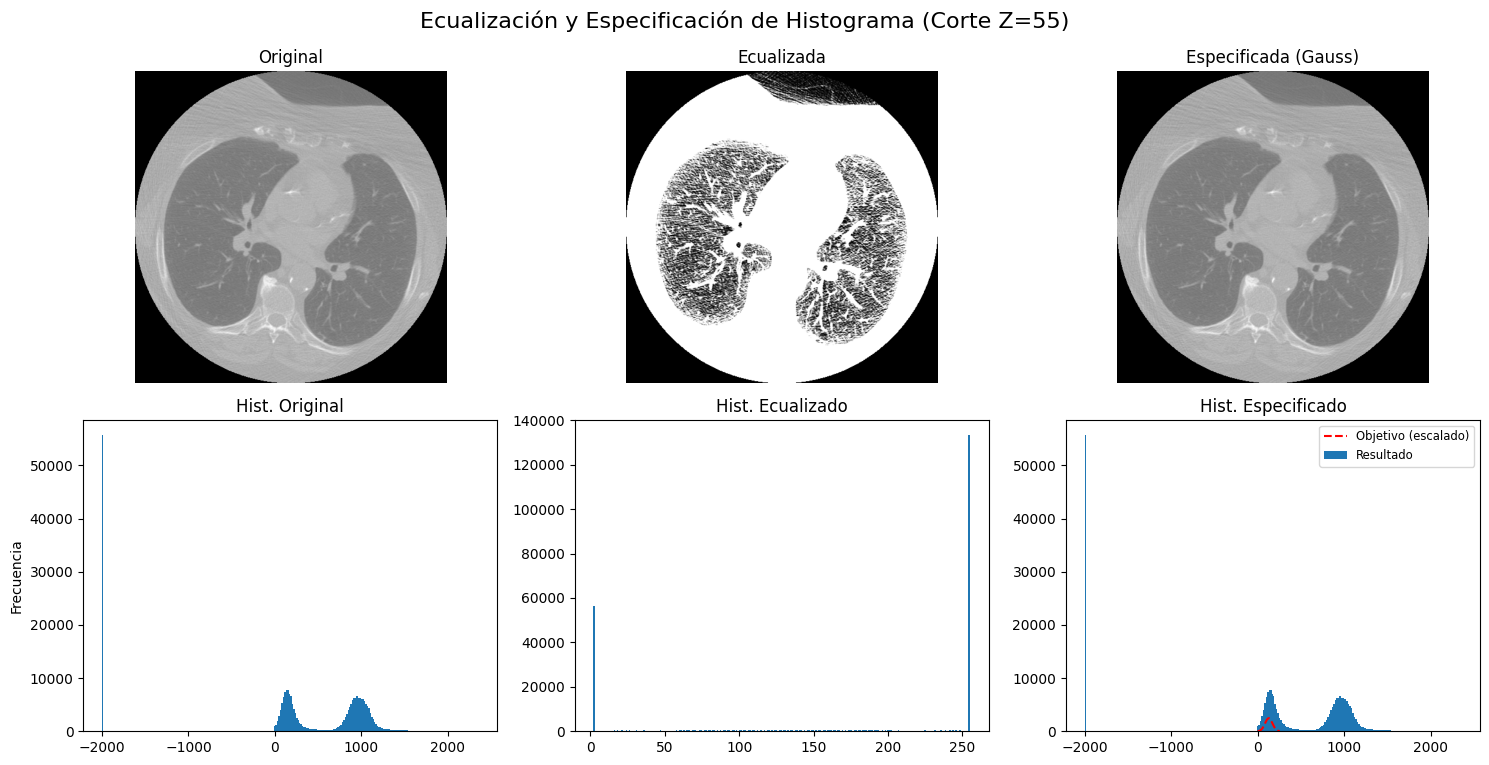


Análisis de Resultados (Histogramas):
Observa las imágenes y sus histogramas:
- Ecualización: Compara el histograma original con el ecualizado. ¿Tiende a ser más plano? ¿Cómo afecta esto al contraste visual de la imagen?
- Especificación: Compara el histograma resultante con el histograma objetivo (Gaussiano en este caso). ¿Se parecen? ¿Cómo se ve la imagen resultante comparada con la original y la ecualizada?
- Aplicabilidad: ¿En qué tipo de imágenes crees que la ecualización sería más útil? ¿Y la especificación?

(Escribe tus explicaciones detalladas en tu informe .ipynb)


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import logging
# Asumimos que 'volume_3d' ya está cargado de pasos anteriores
# Si no, necesitas incluir aquí el código para cargarlo desde data_2

# Configurar el registro básico
logging.basicConfig(level=logging.INFO, format='%(levelname)s: %(message)s')
np.seterr(divide='ignore', invalid='ignore') # Ignorar advertencias comunes

# --- Funciones de Histograma ---

def histogram_equalization(image, num_bins=256):
    """Realiza la ecualización del histograma en una imagen 2D."""
    # Calcular histograma
    # Nota: Si la imagen no es de tipo entero (ej. float), necesita discretizarse o
    # el histograma puede tener muchos bins vacíos. Convertimos a entero si es necesario.
    if np.issubdtype(image.dtype, np.floating):
         # Escalar a [0, num_bins-1] y convertir a entero
         img_min, img_max = np.min(image), np.max(image)
         if img_max > img_min:
             image_int = ((image - img_min) / (img_max - img_min) * (num_bins - 1)).astype(int)
         else:
             image_int = np.zeros_like(image, dtype=int)
    else:
         image_int = image.astype(int) # Asegurar tipo entero

    hist, bin_edges = np.histogram(image_int.flatten(), bins=num_bins, range=(0, num_bins-1))

    # Calcular CDF (Función de Distribución Acumulativa)
    cdf = hist.cumsum()

    # Normalizar CDF al rango [0, num_bins-1]
    # cdf_m = np.ma.masked_equal(cdf, 0) # Enmascarar ceros para la normalización
    # cdf_m = (cdf_m - cdf_m.min()) * (num_bins - 1) / (cdf_m.max() - cdf_m.min())
    # cdf_final = np.ma.filled(cdf_m, 0).astype('uint8') # Rellenar máscara

    # Normalización más simple y común:
    # Escalar por el número total de píxeles para obtener probabilidad [0,1]
    # y luego escalar a [0, num_bins-1]
    cdf_normalized = cdf * (num_bins - 1) / cdf[-1] # cdf[-1] es el número total de píxeles

    # Mapear las intensidades originales usando la CDF normalizada como tabla de búsqueda (LUT)
    equalized_image_int = np.interp(image_int.flatten(), np.arange(num_bins), cdf_normalized)
    equalized_image = equalized_image_int.reshape(image.shape)

    # Si la imagen original era float, devolverla a su rango aproximado (opcional)
    # if np.issubdtype(image.dtype, np.floating):
    #     equalized_image = img_min + (equalized_image / (num_bins - 1)) * (img_max - img_min)

    return equalized_image.astype(image.dtype) # Devolver con el mismo tipo que la entrada

def histogram_specification(image, target_hist, num_bins=256):
    """Realiza la especificación del histograma."""
    # Asegurar que la imagen y el target_hist tengan el mismo número de bins implícito
    if np.issubdtype(image.dtype, np.floating):
         img_min, img_max = np.min(image), np.max(image)
         if img_max > img_min:
             image_int = ((image - img_min) / (img_max - img_min) * (num_bins - 1)).astype(int)
         else:
             image_int = np.zeros_like(image, dtype=int)
    else:
         image_int = image.astype(int)

    # 1. Calcular CDF de la imagen de entrada
    hist_in, _ = np.histogram(image_int.flatten(), bins=num_bins, range=(0, num_bins-1))
    cdf_in = hist_in.cumsum()
    cdf_in_normalized = cdf_in / cdf_in[-1] # Normalizar a [0, 1]

    # 2. Calcular CDF del histograma objetivo
    # Asegurarse de que target_hist tenga la longitud correcta (num_bins)
    if len(target_hist) != num_bins:
        # Interpolar o ajustar target_hist si es necesario (simplificación: error)
        raise ValueError(f"Target histogram debe tener {num_bins} elementos.")
    cdf_target = target_hist.cumsum()
    cdf_target_normalized = cdf_target / cdf_target[-1] # Normalizar a [0, 1]

    # 3. Crear la tabla de mapeo (LUT)
    # Para cada nivel de gris 'g' de la entrada, encontrar el nivel 'z' del objetivo
    # tal que CDF_target(z) >= CDF_in(g)
    lookup_table = np.zeros(num_bins)
    for g in range(num_bins):
        # Encontrar el índice j más pequeño tal que cdf_target[j] >= cdf_in[g]
        j = np.searchsorted(cdf_target_normalized, cdf_in_normalized[g], side='left')
        # Limitar j al rango [0, num_bins-1]
        j = min(j, num_bins - 1)
        lookup_table[g] = j

    # 4. Aplicar el mapeo a la imagen de entrada
    specified_image_int = lookup_table[image_int.flatten()]
    specified_image = specified_image_int.reshape(image.shape)

    # Devolver al rango original si era float (opcional)
    # ...

    return specified_image.astype(image.dtype)


# --- Código Principal ---

# Verificar si volume_3d existe (debe haber sido cargado antes)
if 'volume_3d' not in locals() or volume_3d is None:
    logging.error("La variable 'volume_3d' no está definida o está vacía.")
    logging.error("Asegúrate de haber ejecutado los pasos anteriores para cargar datos de data_2.")
else:
    # Seleccionar un corte de ejemplo (ej. el central)
    slice_index = volume_3d.shape[0] // 2
    original_slice = volume_3d[slice_index]
    logging.info(f"Procesando corte axial Z = {slice_index}")

    # Aplicar Ecualización
    try:
        equalized_slice = histogram_equalization(original_slice)
        logging.info("Ecualización de histograma completada.")
    except Exception as e:
        logging.error(f"Error en ecualización: {e}")
        equalized_slice = original_slice # Poner original si falla

    # Aplicar Especificación
    # Crear un histograma objetivo de ejemplo (ej. Gaussiano centrado)
    num_bins_spec = 256
    bins = np.arange(num_bins_spec)
    mean = num_bins_spec / 2
    std_dev = num_bins_spec / 6
    target_hist_gaussian = np.exp(-((bins - mean)**2 / (2 * std_dev**2)))
    # Normalizar para que sume como un histograma (aunque la CDF es lo importante)
    target_hist_gaussian /= target_hist_gaussian.sum()
    # Multiplicar por un número grande para simular cuentas
    target_hist_gaussian *= original_slice.size

    try:
        specified_slice = histogram_specification(original_slice, target_hist_gaussian, num_bins=num_bins_spec)
        logging.info("Especificación de histograma completada (objetivo Gaussiano).")
    except Exception as e:
        logging.error(f"Error en especificación: {e}")
        specified_slice = original_slice # Poner original si falla


    # --- Visualización ---
    fig, axes = plt.subplots(2, 3, figsize=(15, 8)) # 2 filas (imagen, histograma), 3 columnas

    # Imagen Original
    ax = axes[0, 0]
    im = ax.imshow(original_slice, cmap=plt.cm.gray)
    ax.set_title('Original')
    ax.axis('off')
    # fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04) # Opcional: barra de color

    # Histograma Original
    ax = axes[1, 0]
    hist_orig, bins_orig = np.histogram(original_slice.ravel(), bins=256)
    center_orig = (bins_orig[:-1] + bins_orig[1:]) / 2
    ax.bar(center_orig, hist_orig, width=(bins_orig[1]-bins_orig[0]))
    ax.set_title('Hist. Original')
    ax.set_ylabel('Frecuencia')


    # Imagen Ecualizada
    ax = axes[0, 1]
    im = ax.imshow(equalized_slice, cmap=plt.cm.gray)
    ax.set_title('Ecualizada')
    ax.axis('off')
    # fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)

    # Histograma Ecualizado
    ax = axes[1, 1]
    hist_eq, bins_eq = np.histogram(equalized_slice.ravel(), bins=256)
    center_eq = (bins_eq[:-1] + bins_eq[1:]) / 2
    ax.bar(center_eq, hist_eq, width=(bins_eq[1]-bins_eq[0]))
    ax.set_title('Hist. Ecualizado')


    # Imagen Especificada
    ax = axes[0, 2]
    im = ax.imshow(specified_slice, cmap=plt.cm.gray)
    ax.set_title('Especificada (Gauss)')
    ax.axis('off')
    # fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)

    # Histograma Especificado
    ax = axes[1, 2]
    hist_spec, bins_spec = np.histogram(specified_slice.ravel(), bins=256)
    center_spec = (bins_spec[:-1] + bins_spec[1:]) / 2
    ax.bar(center_spec, hist_spec, width=(bins_spec[1]-bins_spec[0]), label='Resultado')
    # Superponer el objetivo (escalado) para comparar
    ax.plot(np.arange(num_bins_spec), target_hist_gaussian * (hist_spec.sum() / target_hist_gaussian.sum()),
            color='red', linestyle='--', label='Objetivo (escalado)')
    ax.set_title('Hist. Especificado')
    ax.legend(fontsize='small')


    plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Ajustar layout, dejar espacio para título general
    fig.suptitle(f'Ecualización y Especificación de Histograma (Corte Z={slice_index})', fontsize=16)
    plt.show()

    # --- Comentarios ---
    print("\n" + "="*30)
    print("Análisis de Resultados (Histogramas):")
    print("="*30)
    print("Observa las imágenes y sus histogramas:")
    print("- Ecualización: Compara el histograma original con el ecualizado. ¿Tiende a ser más plano? ¿Cómo afecta esto al contraste visual de la imagen?")
    print("- Especificación: Compara el histograma resultante con el histograma objetivo (Gaussiano en este caso). ¿Se parecen? ¿Cómo se ve la imagen resultante comparada con la original y la ecualizada?")
    print("- Aplicabilidad: ¿En qué tipo de imágenes crees que la ecualización sería más útil? ¿Y la especificación?")
    print("\n(Escribe tus explicaciones detalladas en tu informe .ipynb)")

INFO: Procesando filtros en corte axial Z = 55
INFO: Filtros manuales aplicados.
INFO: Filtro promedio aplicado con SciPy.
INFO: ¿Resultado manual y SciPy para filtro promedio son cercanos? True


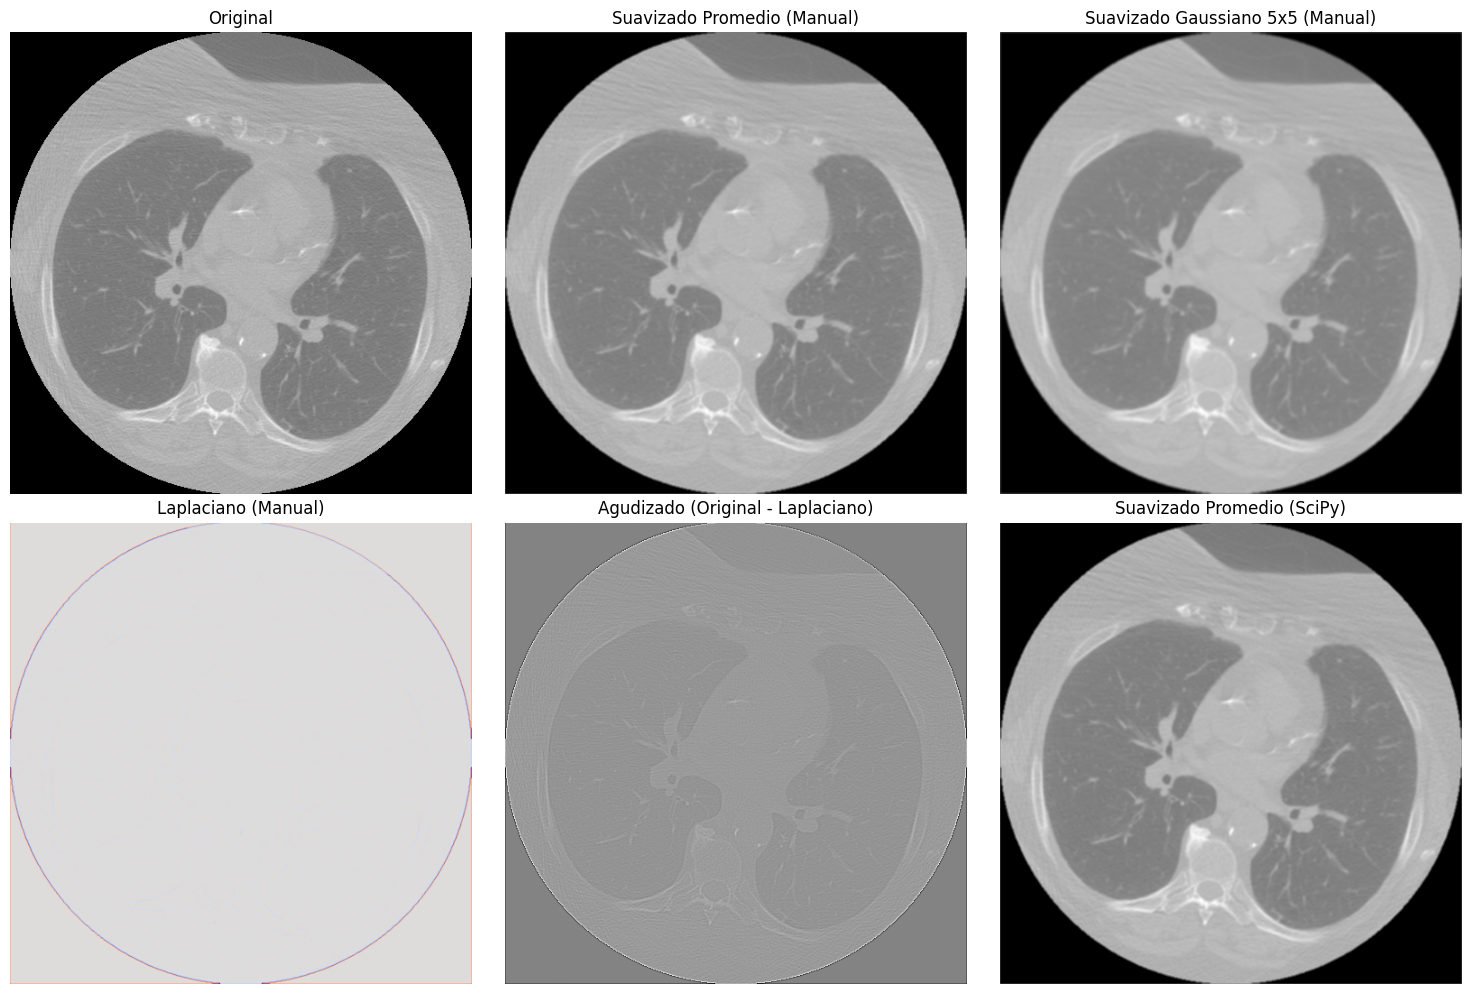

In [ ]:
# Importar las bibliotecas necesarias
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import convolve as scipy_convolve # Para comparar
import logging
# Asumimos que 'volume_3d' ya está cargado de pasos anteriores
# Si no, necesitas incluir aquí el código para cargarlo desde data_2

# Configurar el registro básico
logging.basicConfig(level=logging.INFO, format='%(levelname)s: %(message)s')

# --- Implementación Manual de Convolución 2D ---

def manual_convolve2d(image, kernel):
    """
    Realiza una convolución 2D manualmente entre una imagen y un kernel.
    Maneja bordes usando padding con ceros.
    """
    # Obtener dimensiones
    img_rows, img_cols = image.shape
    ker_rows, ker_cols = kernel.shape

    # Calcular padding necesario para mantener el tamaño de salida igual al de entrada
    # Asumimos que el kernel tiene dimensiones impares
    pad_rows = ker_rows // 2
    pad_cols = ker_cols // 2

    # Crear imagen con padding (usando la idea del hint [cite: 33])
    # np.pad rellena los bordes
    image_padded = np.pad(image, ((pad_rows, pad_rows), (pad_cols, pad_cols)),
                          mode='constant', constant_values=0)

    # Crear la imagen de salida (inicializada con ceros)
    output_image = np.zeros_like(image, dtype=np.float64) # Usar float para evitar overflow

    # Voltear el kernel (paso estándar en definición de convolución matemática)
    # Aunque para kernels simétricos (como promedio, Gaussiano, Laplaciano simple) no hace diferencia.
    kernel_flipped = np.flipud(np.fliplr(kernel))

    # Realizar la convolución iterando sobre la imagen original (no la acolchada)
    for r in range(img_rows):
        for c in range(img_cols):
            # Extraer la región de la imagen acolchada correspondiente al kernel
            # Los índices (r, c) de la imagen original corresponden a (r+pad_rows, c+pad_cols) en la acolchada
            image_region = image_padded[r : r + ker_rows, c : c + ker_cols]

            # Realizar la multiplicación elemento a elemento y sumar
            output_pixel = np.sum(image_region * kernel_flipped)
            output_image[r, c] = output_pixel

    # Convertir al tipo de dato original si es necesario (o mantener float)
    # return output_image.astype(image.dtype)
    return output_image


# --- Definición de Kernels ---

# 1. Suavizado: Filtro Promedio (Box Blur) 3x3
kernel_avg_3x3 = np.ones((3, 3), dtype=np.float64) / 9.0

# 2. Suavizado: Filtro Gaussiano (ejemplo 3x3, sigma=1)
def gaussian_kernel(size, sigma=1.0):
    """Genera un kernel Gaussiano 2D."""
    if size % 2 == 0:
        raise ValueError("El tamaño del kernel debe ser impar")
    ax = np.arange(-size // 2 + 1.0, size // 2 + 1.0)
    xx, yy = np.meshgrid(ax, ax)
    kernel = np.exp(-(xx**2 + yy**2) / (2.0 * sigma**2))
    return kernel / np.sum(kernel) # Normalizar para que sume 1

kernel_gaussian_3x3 = gaussian_kernel(size=3, sigma=1.0)
kernel_gaussian_5x5 = gaussian_kernel(size=5, sigma=1.5)


# 3. Agudizado: Filtro Laplaciano (ejemplo simple)
# Suma 0, detecta bordes/cambios rápidos
kernel_laplacian_4 = np.array([[ 0,  1,  0],
                               [ 1, -4,  1],
                               [ 0,  1,  0]], dtype=np.float64)

kernel_laplacian_8 = np.array([[ 1,  1,  1],
                               [ 1, -8,  1],
                               [ 1,  1,  1]], dtype=np.float64)


# --- Aplicación y Comparación ---

# Verificar si volume_3d existe
if 'volume_3d' not in locals() or volume_3d is None:
    logging.error("La variable 'volume_3d' no está definida o está vacía.")
else:
    # Seleccionar un corte de ejemplo
    slice_index = volume_3d.shape[0] // 2
    original_slice = volume_3d[slice_index].astype(np.float64) # Convertir a float para cálculos
    logging.info(f"Procesando filtros en corte axial Z = {slice_index}")

    # Aplicar filtros usando la convolución manual
    try:
        blurred_manual = manual_convolve2d(original_slice, kernel_avg_3x3)
        gaussian_manual = manual_convolve2d(original_slice, kernel_gaussian_5x5)
        laplacian_manual = manual_convolve2d(original_slice, kernel_laplacian_8)

        # Imagen agudizada = original - laplaciano (o original + (-laplaciano))
        sharpened_manual = original_slice - laplacian_manual
        logging.info("Filtros manuales aplicados.")

        # Comparar el filtro promedio con scipy.ndimage.convolve
        # Nota: scipy.ndimage.convolve realiza correlación por defecto.
        # Para convolución, el kernel debe voltearse o usar reflect mode si es simétrico.
        # O más simple: pasar el kernel tal cual, el resultado será el mismo si es simétrico.
        blurred_scipy = scipy_convolve(original_slice, kernel_avg_3x3, mode='constant', cval=0.0)
        logging.info("Filtro promedio aplicado con SciPy.")

        # Verificar si los resultados son numéricamente cercanos
        are_close = np.allclose(blurred_manual, blurred_scipy)
        logging.info(f"¿Resultado manual y SciPy para filtro promedio son cercanos? {are_close}")
        if not are_close:
             diff = np.abs(blurred_manual - blurred_scipy)
             logging.warning(f"Diferencia máxima encontrada: {np.max(diff)}")
             logging.warning("Pequeñas diferencias pueden deberse a precisión numérica o manejo de bordes.")


        # --- Visualización ---
        fig, axes = plt.subplots(2, 3, figsize=(15, 10))

        axes[0, 0].imshow(original_slice, cmap='gray')
        axes[0, 0].set_title('Original')
        axes[0, 0].axis('off')

        axes[0, 1].imshow(blurred_manual, cmap='gray')
        axes[0, 1].set_title('Suavizado Promedio (Manual)')
        axes[0, 1].axis('off')

        axes[0, 2].imshow(gaussian_manual, cmap='gray')
        axes[0, 2].set_title('Suavizado Gaussiano 5x5 (Manual)')
        axes[0, 2].axis('off')

        # El Laplaciano suele tener valores negativos y positivos, centrado en cero
        # Escalar para visualizar o usar un mapa de color divergente
        axes[1, 0].imshow(laplacian_manual, cmap='coolwarm', vmin=-np.max(np.abs(laplacian_manual)), vmax=np.max(np.abs(laplacian_manual)))
        axes[1, 0].set_title('Laplaciano (Manual)')
        axes[1, 0].axis('off')

        axes[1, 1].imshow(sharpened_manual, cmap='gray')
        axes[1, 1].set_title('Agudizado (Original - Laplaciano)')
        axes[1, 1].axis('off')

        axes[1, 2].imshow(blurred_scipy, cmap='gray')
        axes[1, 2].set_title('Suavizado Promedio (SciPy)')
        axes[1, 2].axis('off')

        plt.tight_layout()
        plt.show()

    except Exception as e:
        logging.error(f"Error durante la aplicación de filtros o visualización: {e}")

INFO: Procesando archivo: ./Tarea_1/datos/xray.dcm
INFO: Imagen original leída con dimensiones: (1024, 1024)
INFO: Paso 1: Suavizando la imagen original...
INFO: Imagen suavizada generada.
INFO: Paso 2: Calculando la máscara de detalles...
INFO: Máscara de detalles generada.
INFO: Paso 3: Sumando la máscara ponderada (k=1.5) a la original...
INFO: Imagen agudizada generada.


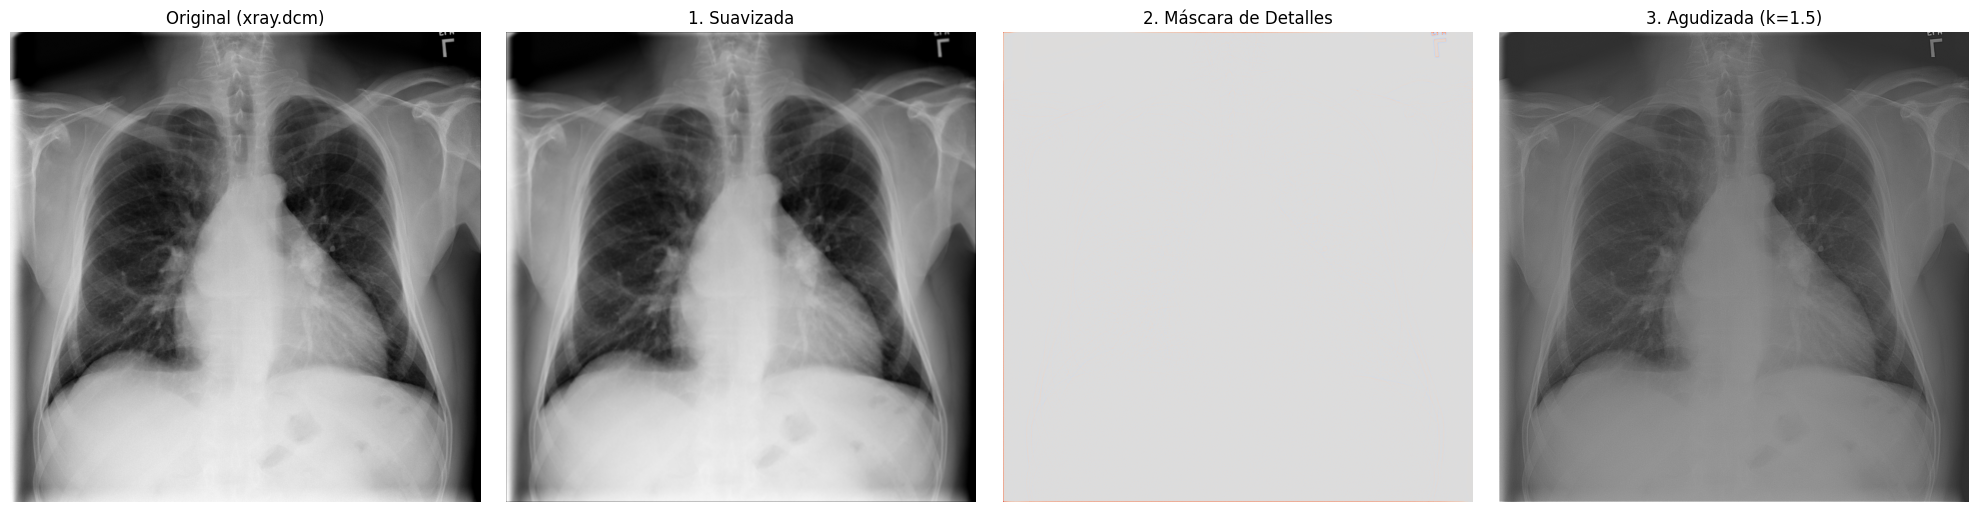


Explicación de la Pertinencia de los Pasos:
1. Suavizado:
   - Propósito: Eliminar o atenuar los detalles finos (altas frecuencias) de la imagen, conservando las características generales (bajas frecuencias).
   - Pertinencia: Al restar esta versión suavizada de la original, aislamos precisamente esos detalles que fueron eliminados.

2. Cálculo de la Máscara (Original - Suavizada):
   - Propósito: Obtener una imagen que represente la información de alta frecuencia (bordes, texturas, ruido) presente en la original.
   - Pertinencia: Esta máscara contiene la 'nitidez' que queremos realzar.

3. Suma Ponderada (Original + k * Máscara):
   - Propósito: Reincorporar los detalles (la máscara) a la imagen original, potenciándolos mediante el factor 'k'.
   - Pertinencia: Si k=1 (Unsharp Masking), se restauran aproximadamente los detalles originales. Si k>1 (High-boost), se exageran los detalles, resultando en una imagen percibida como más nítida o 'agudizada'.

(Elabora estas ideas con tus pr

In [ ]:
# Importar las bibliotecas necesarias
import os
import pydicom
import numpy as np
import matplotlib.pyplot as plt
import logging
# Asumimos que las funciones 'manual_convolve2d' y 'gaussian_kernel'
# están definidas de la Tarea 3.2.1

# Configurar el registro básico
logging.basicConfig(level=logging.INFO, format='%(levelname)s: %(message)s')

# --- Configuración ---
# !!! IMPORTANTE: Reemplaza esto con la ruta COMPLETA al archivo xray.dcm !!!
xray_filepath = './Tarea_1/datos/xray.dcm'

# Parámetro k para High-Boost filtering (k=1 para Unsharp Masking estándar)
k_factor = 1.5 # Puedes probar k=1, 1.5, 2.0, etc.

# Kernel para el suavizado inicial (puedes usar avg o gaussiano)
# Usaremos Gaussiano 5x5 de la tarea anterior como ejemplo
try:
    smoothing_kernel = gaussian_kernel(size=5, sigma=1.5)
except NameError:
    logging.error("La función 'gaussian_kernel' no está definida. Usando promedio.")
    smoothing_kernel = np.ones((5, 5), dtype=np.float64) / 25.0
# --- Fin de Configuración ---


# Verificar si el archivo existe
if not os.path.isfile(xray_filepath):
    logging.error(f"El archivo especificado no existe: {xray_filepath}")
else:
    logging.info(f"Procesando archivo: {xray_filepath}")
    try:
        # Leer la imagen DICOM
        ds = pydicom.dcmread(xray_filepath)
        if 'PixelData' not in ds:
            logging.error("El archivo DICOM no contiene datos de imagen (PixelData).")
        else:
            original_image = ds.pixel_array.astype(np.float64) # Usar float
            logging.info(f"Imagen original leída con dimensiones: {original_image.shape}")

            # --- Aplicación de Unsharp Masking / High-Boost ---

            # Paso 1: Suavizar la imagen original usando la convolución manual
            logging.info("Paso 1: Suavizando la imagen original...")
            try:
                 blurred_image = manual_convolve2d(original_image, smoothing_kernel)
                 logging.info("Imagen suavizada generada.")
            except NameError:
                 logging.error("La función 'manual_convolve2d' no está definida. No se puede continuar.")
                 # exit() # Salir si la función manual no está
                 raise # Relanzar el error
            except Exception as e:
                 logging.error(f"Error durante el suavizado manual: {e}")
                 raise

            # Paso 2: Crear la máscara de detalles (original - suavizada)
            logging.info("Paso 2: Calculando la máscara de detalles...")
            detail_mask = original_image - blurred_image
            logging.info("Máscara de detalles generada.")

            # Paso 3: Sumar la máscara (ponderada) a la original
            logging.info(f"Paso 3: Sumando la máscara ponderada (k={k_factor}) a la original...")
            sharpened_image = original_image + k_factor * detail_mask
            # Opcional: Recortar valores si salen del rango esperado (ej. 0-255 para uint8)
            # sharpened_image = np.clip(sharpened_image, 0, 255) # Ajusta el rango si es necesario
            logging.info("Imagen agudizada generada.")


            # --- Visualización ---
            fig, axes = plt.subplots(1, 4, figsize=(20, 5))

            axes[0].imshow(original_image, cmap='gray')
            axes[0].set_title('Original (xray.dcm)')
            axes[0].axis('off')

            axes[1].imshow(blurred_image, cmap='gray')
            axes[1].set_title('1. Suavizada')
            axes[1].axis('off')

            # La máscara de detalles puede tener valores negativos/positivos
            max_abs_mask = np.max(np.abs(detail_mask))
            axes[2].imshow(detail_mask, cmap='coolwarm', vmin=-max_abs_mask, vmax=max_abs_mask)
            axes[2].set_title('2. Máscara de Detalles')
            axes[2].axis('off')

            axes[3].imshow(sharpened_image, cmap='gray')
            axes[3].set_title(f'3. Agudizada (k={k_factor})')
            axes[3].axis('off')

            plt.tight_layout()
            plt.show()

            # --- Explicación ---
            print("\n" + "="*40)
            print("Explicación de la Pertinencia de los Pasos:")
            print("="*40)
            print("1. Suavizado:")
            print("   - Propósito: Eliminar o atenuar los detalles finos (altas frecuencias) de la imagen, conservando las características generales (bajas frecuencias).")
            print("   - Pertinencia: Al restar esta versión suavizada de la original, aislamos precisamente esos detalles que fueron eliminados.")
            print("\n2. Cálculo de la Máscara (Original - Suavizada):")
            print("   - Propósito: Obtener una imagen que represente la información de alta frecuencia (bordes, texturas, ruido) presente en la original.")
            print("   - Pertinencia: Esta máscara contiene la 'nitidez' que queremos realzar.")
            print("\n3. Suma Ponderada (Original + k * Máscara):")
            print("   - Propósito: Reincorporar los detalles (la máscara) a la imagen original, potenciándolos mediante el factor 'k'.")
            print("   - Pertinencia: Si k=1 (Unsharp Masking), se restauran aproximadamente los detalles originales. Si k>1 (High-boost), se exageran los detalles, resultando en una imagen percibida como más nítida o 'agudizada'.")
            print("\n(Elabora estas ideas con tus propias palabras y observaciones en tu informe .ipynb)")


    except pydicom.errors.InvalidDicomError:
        logging.error(f"El archivo no es un DICOM válido: {xray_filepath}")
    except Exception as e:
        logging.error(f"Ocurrió un error inesperado: {e}")

INFO: Usando kernel Gaussiano 5x5 para suavizar.
INFO: Cargando imagen desde: ./Tarea_1/datos/xray.dcm
INFO: Imagen cargada: (1024, 1024)
INFO: Imagen suavizada generada.
INFO: Calculando SNR para ROI: (900, 950, 400, 450)
INFO: Original -> mu=231.42, sigma=3.40, SNR=67.98
INFO: Suavizada -> mu=231.43, sigma=2.76, SNR=83.84


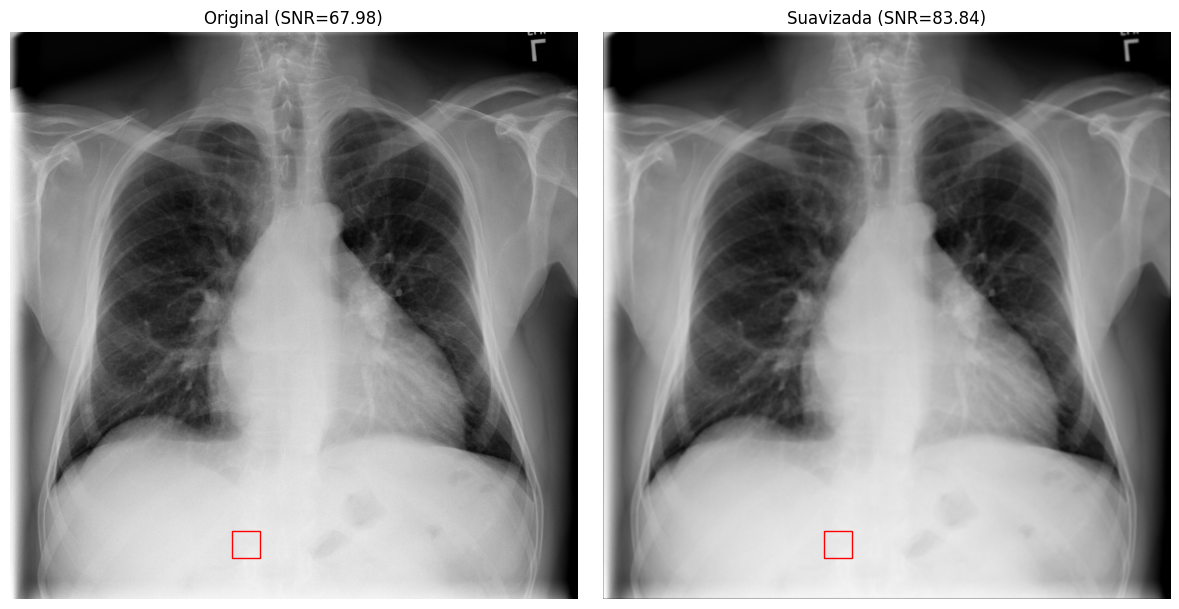


Discusión sobre los Resultados de SNR:
SNR Original: 67.98
SNR Suavizada: 83.84
Observación: La SNR aumentó después del suavizado.
Posible Razón: El filtro redujo la desviación estándar (ruido, sigma) en la región homogénea más significativamente de lo que afectó la media (señal, mu).

Considera:
- ¿Era la ROI seleccionada realmente homogénea? ¿Cómo afectaría una ROI no homogénea al resultado?
- ¿Cómo cambiaría la SNR si se usara un filtro de suavizado más fuerte (kernel más grande o sigma mayor)?
- ¿Qué mide realmente la SNR en este contexto? (Relación señal/ruido local en una región supuestamente uniforme)

(Elabora estas ideas y tus conclusiones en tu informe .ipynb)


In [ ]:
# Importar las bibliotecas necesarias
import os
import pydicom
import numpy as np
import matplotlib.pyplot as plt
import logging
# Asumimos que las funciones 'manual_convolve2d' y 'gaussian_kernel'
# están definidas de la Tarea 3.2.1

# Configurar el registro básico
logging.basicConfig(level=logging.INFO, format='%(levelname)s: %(message)s')

# --- Configuración ---
# !!! IMPORTANTE: Reemplaza esto con la ruta COMPLETA al archivo a usar !!!
# Usaremos xray.dcm como ejemplo, pero podría ser un slice de volume_3d
image_filepath = './Tarea_1/datos/xray.dcm'
# image_slice = volume_3d[slice_index] # Alternativa si usas data_2

# !!! IMPORTANTE: Define las coordenadas de tu ROI homogénea aquí !!!
# Debes buscar una región en la imagen original que parezca tener intensidad uniforme.
# Formato: (fila_inicio, fila_fin, col_inicio, col_fin)
# Estos valores son EJEMPLOS para xray.dcm, ¡AJÚSTALOS mirando tu imagen!
# Puedes usar un visor de imágenes para encontrar coordenadas adecuadas.
# Ejemplo ROI (ajustar según tu imagen xray.dcm):
roi_coords = (900, 950, 400, 450) # (y_start, y_end, x_start, x_end)

# Kernel para el suavizado (usaremos Gaussiano 5x5 como ejemplo)
try:
    smoothing_kernel = gaussian_kernel(size=5, sigma=1.5)
    logging.info("Usando kernel Gaussiano 5x5 para suavizar.")
except NameError:
    logging.error("Función 'gaussian_kernel' no definida. Usando promedio.")
    smoothing_kernel = np.ones((5, 5), dtype=np.float64) / 25.0
# --- Fin de Configuración ---

# --- Función para calcular SNR en ROI ---
def calculate_snr_in_roi(image, roi_coords):
    """Calcula mu, sigma y SNR dentro de una ROI."""
    y_start, y_end, x_start, x_end = roi_coords
    roi_pixels = image[y_start:y_end, x_start:x_end]

    if roi_pixels.size == 0:
        logging.warning("La ROI definida está vacía o fuera de límites.")
        return np.nan, np.nan, np.nan # Devolver NaN si la ROI es inválida

    mu = np.mean(roi_pixels)
    sigma = np.std(roi_pixels)

    if sigma == 0: # Evitar división por cero si la región es perfectamente constante
        snr = np.inf
    else:
        snr = mu / sigma

    return mu, sigma, snr

# --- Código Principal ---

image_loaded = False
# Cargar la imagen (ya sea desde archivo o desde volume_3d)
if 'image_slice' in locals() and isinstance(image_slice, np.ndarray):
     original_image = image_slice.astype(np.float64)
     image_loaded = True
     logging.info("Usando 'image_slice' predefinida.")
elif os.path.isfile(image_filepath):
    logging.info(f"Cargando imagen desde: {image_filepath}")
    try:
        ds = pydicom.dcmread(image_filepath)
        if 'PixelData' in ds:
            original_image = ds.pixel_array.astype(np.float64)
            image_loaded = True
            logging.info(f"Imagen cargada: {original_image.shape}")
        else:
            logging.error("Archivo DICOM no contiene PixelData.")
    except Exception as e:
        logging.error(f"Error cargando {image_filepath}: {e}")
else:
     logging.error("No se especificó una imagen válida (ni archivo ni 'image_slice').")


if image_loaded:
    # Aplicar el filtro de suavizado
    try:
        smoothed_image = manual_convolve2d(original_image, smoothing_kernel)
        logging.info("Imagen suavizada generada.")
    except NameError:
         logging.error("Función 'manual_convolve2d' no definida. No se puede continuar.")
         # exit()
         smoothed_image = None # Marcar como no disponible
    except Exception as e:
         logging.error(f"Error durante el suavizado manual: {e}")
         smoothed_image = None

    # Calcular SNR antes y después (si el suavizado tuvo éxito)
    logging.info(f"Calculando SNR para ROI: {roi_coords}")

    mu_orig, sigma_orig, snr_orig = calculate_snr_in_roi(original_image, roi_coords)
    logging.info(f"Original -> mu={mu_orig:.2f}, sigma={sigma_orig:.2f}, SNR={snr_orig:.2f}")

    if smoothed_image is not None:
        mu_smooth, sigma_smooth, snr_smooth = calculate_snr_in_roi(smoothed_image, roi_coords)
        logging.info(f"Suavizada -> mu={mu_smooth:.2f}, sigma={sigma_smooth:.2f}, SNR={snr_smooth:.2f}")
    else:
        logging.warning("No se pudo calcular SNR para la imagen suavizada debido a errores previos.")
        mu_smooth, sigma_smooth, snr_smooth = np.nan, np.nan, np.nan


    # --- Visualización (Opcional pero útil) ---
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))

    # Mostrar Original con ROI
    axes[0].imshow(original_image, cmap='gray')
    axes[0].set_title(f'Original (SNR={snr_orig:.2f})')
    axes[0].axis('off')
    # Dibujar el rectángulo de la ROI
    y_start, y_end, x_start, x_end = roi_coords
    rect = plt.Rectangle((x_start, y_start), x_end - x_start, y_end - y_start,
                         linewidth=1, edgecolor='r', facecolor='none')
    axes[0].add_patch(rect)

    # Mostrar Suavizada con ROI
    if smoothed_image is not None:
        axes[1].imshow(smoothed_image, cmap='gray')
        axes[1].set_title(f'Suavizada (SNR={snr_smooth:.2f})')
        axes[1].axis('off')
        rect = plt.Rectangle((x_start, y_start), x_end - x_start, y_end - y_start,
                         linewidth=1, edgecolor='r', facecolor='none')
        axes[1].add_patch(rect)
    else:
         axes[1].set_title('Suavizada (Error)')
         axes[1].text(0.5, 0.5, 'Error al generar imagen suavizada',
                      ha='center', va='center', transform=axes[1].transAxes)
         axes[1].axis('off')


    plt.tight_layout()
    plt.show()


    # --- Discusión ---
    print("\n" + "="*30)
    print("Discusión sobre los Resultados de SNR:")
    print("="*30)
    print(f"SNR Original: {snr_orig:.2f}")
    if smoothed_image is not None:
        print(f"SNR Suavizada: {snr_smooth:.2f}")
        if snr_smooth > snr_orig:
             print("Observación: La SNR aumentó después del suavizado.")
             print("Posible Razón: El filtro redujo la desviación estándar (ruido, sigma) en la región homogénea más significativamente de lo que afectó la media (señal, mu).")
        elif snr_smooth < snr_orig:
             print("Observación: La SNR disminuyó después del suavizado.")
             print("Posible Razón: El filtro afectó la señal promedio (mu) más de lo que redujo la desviación estándar (sigma), o la ROI no era perfectamente homogénea.")
        else:
             print("Observación: La SNR no cambió significativamente.")
    else:
         print("No se pudo calcular SNR para la imagen suavizada.")

    print("\nConsidera:")
    print("- ¿Era la ROI seleccionada realmente homogénea? ¿Cómo afectaría una ROI no homogénea al resultado?")
    print("- ¿Cómo cambiaría la SNR si se usara un filtro de suavizado más fuerte (kernel más grande o sigma mayor)?")
    print("- ¿Qué mide realmente la SNR en este contexto? (Relación señal/ruido local en una región supuestamente uniforme)")
    print("\n(Elabora estas ideas y tus conclusiones en tu informe .ipynb)")

INFO: Cargando imagen anatómica: ./Tarea_1/datos\anat.nii
INFO:   Dimensiones anat_data: (41, 48, 40), Tipo: float64
INFO: Cargando Z-map voice: ./Tarea_1/datos\zmap_voice.nii
INFO:   Dimensiones zmap_voice_data: (41, 48, 40), Tipo: float64
INFO: Cargando Z-map non-voice: ./Tarea_1/datos\zmap_nonvoice.nii
INFO:   Dimensiones zmap_nonvoice_data: (41, 48, 40), Tipo: float64
INFO: Usando vmin=0.04, vmax_voice=0.06, vmax_nonvoice=0.04


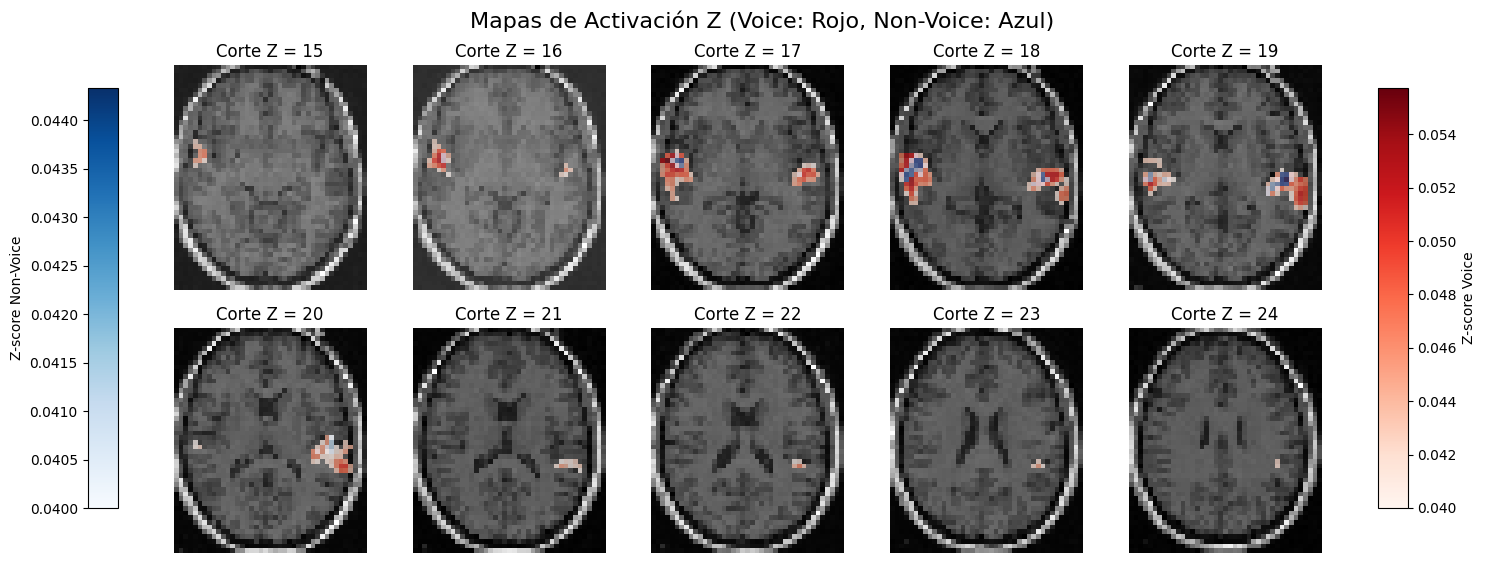

In [ ]:
# Importar las bibliotecas necesarias
import os
import nibabel as nib # Para leer archivos NIfTI
import numpy as np
import matplotlib.pyplot as plt
import logging

# Configurar el registro básico
logging.basicConfig(level=logging.INFO, format='%(levelname)s: %(message)s')

# --- Configuración ---
# !!! IMPORTANTE: Reemplaza esto con las rutas REALES a tus archivos NIfTI !!!
# Asegúrate de que esta ruta es correcta desde donde ejecutas el notebook
nii_dir = './Tarea_1/datos' # Directorio donde están los .nii/.nii.gz

# !!! IMPORTANTE: Verifica si tus archivos zmap son .nii o .nii.gz !!!
anat_filename = 'anat.nii'
zmap_voice_filename = 'zmap_voice.nii' # O 'zmap_voice.nii.gz' ?
zmap_nonvoice_filename = 'zmap_nonvoice.nii' # O 'zmap_nonvoice.nii.gz' ?

anat_filepath = os.path.join(nii_dir, anat_filename)
zmap_voice_filepath = os.path.join(nii_dir, zmap_voice_filename)
zmap_nonvoice_filepath = os.path.join(nii_dir, zmap_nonvoice_filename)

# Parámetros de visualización
# !!! IMPORTANTE: Ajusta este rango según las dimensiones de tus NIfTI !!!
slice_indices_to_show = range(15, 25) # Rango de cortes axiales a mostrar (ejemplo)

threshold_zmap = 0.04 # Umbral para mostrar activaciones (ej. Z > 3)
alpha_overlay = 0.7 # Transparencia de la superposición (0=transparente, 1=opaco)
cmap_voice = 'Reds' # Mapa de color para 'voice'
cmap_nonvoice = 'Blues' # Mapa de color para 'non-voice'
# --- Fin de Configuración ---


# --- Carga de Datos NIfTI ---
anat_data = None # Inicializar variables
zmap_voice_data = None
zmap_nonvoice_data = None

try:
    logging.info(f"Cargando imagen anatómica: {anat_filepath}")
    if not os.path.exists(anat_filepath): raise FileNotFoundError(anat_filepath)
    anat_img = nib.load(anat_filepath)
    anat_data = anat_img.get_fdata() # Obtener datos como array NumPy
    logging.info(f"  Dimensiones anat_data: {anat_data.shape}, Tipo: {anat_data.dtype}")

    logging.info(f"Cargando Z-map voice: {zmap_voice_filepath}")
    if not os.path.exists(zmap_voice_filepath): raise FileNotFoundError(zmap_voice_filepath)
    zmap_voice_img = nib.load(zmap_voice_filepath)
    zmap_voice_data = zmap_voice_img.get_fdata()
    logging.info(f"  Dimensiones zmap_voice_data: {zmap_voice_data.shape}, Tipo: {zmap_voice_data.dtype}")

    logging.info(f"Cargando Z-map non-voice: {zmap_nonvoice_filepath}")
    if not os.path.exists(zmap_nonvoice_filepath): raise FileNotFoundError(zmap_nonvoice_filepath)
    zmap_nonvoice_img = nib.load(zmap_nonvoice_filepath)
    zmap_nonvoice_data = zmap_nonvoice_img.get_fdata()
    logging.info(f"  Dimensiones zmap_nonvoice_data: {zmap_nonvoice_data.shape}, Tipo: {zmap_nonvoice_data.dtype}")

    # Verificar compatibilidad de dimensiones (simple)
    if not (anat_data.shape == zmap_voice_data.shape == zmap_nonvoice_data.shape):
         logging.warning("Las dimensiones de los archivos NIfTI no coinciden exactamente.")
         # Podría requerir remuestreo, pero asumimos compatibilidad aquí.

except FileNotFoundError as e:
    logging.error(f"Error: No se encontró el archivo NIfTI: {e}")
except Exception as e:
    logging.error(f"Error cargando archivos NIfTI: {e}")


# --- Visualización ---
# Proceder solo si todos los datos necesarios fueron cargados
if anat_data is not None and zmap_voice_data is not None and zmap_nonvoice_data is not None:
    num_slices_to_show = len(slice_indices_to_show)
    # Calcular dimensiones de la cuadrícula
    cols = 5 # Fijar número de columnas (ajustar si se quieren más/menos)
    rows = int(np.ceil(num_slices_to_show / cols))

    fig, axes = plt.subplots(rows, cols, figsize=(cols * 3, rows * 3), squeeze=False) # squeeze=False asegura que axes sea siempre 2D
    axes = axes.ravel() # Aplanar para iterar fácilmente

    # --- Calcular vmax ANTES del bucle para asegurar que existen ---
    # Añadir un pequeño épsilon para evitar vmin=vmax si max == threshold
    epsilon = 1e-6
    vmax_voice = max(np.max(zmap_voice_data), threshold_zmap + epsilon)
    vmax_nonvoice = max(np.max(zmap_nonvoice_data), threshold_zmap + epsilon)
    # Alternativa: Fijar un límite superior esperado, ej: vmax_voice = 7
    logging.info(f"Usando vmin={threshold_zmap}, vmax_voice={vmax_voice:.2f}, vmax_nonvoice={vmax_nonvoice:.2f}")


    img_counter = 0
    for i, slice_idx in enumerate(slice_indices_to_show):
        if i >= len(axes): # No mostrar más imágenes si no hay ejes
            break

        ax = axes[i]

        # Obtener el corte axial anatómico
        try:
            # Los datos NIfTI suelen ser (X, Y, Z), así que el corte axial es [:, :, slice_idx]
            if slice_idx >= anat_data.shape[2]: # Verificar índice Z
                 raise IndexError(f"Índice de corte Z {slice_idx} fuera de rango (max: {anat_data.shape[2]-1})")
            anat_slice = anat_data[:, :, slice_idx]
        except IndexError as e:
            logging.warning(f"Error al obtener corte {slice_idx} de anat_data: {e}. Omitiendo.")
            ax.axis('off')
            continue # Saltar al siguiente corte

        # Mostrar la imagen anatómica de fondo (rotada)
        ax.imshow(np.rot90(anat_slice), cmap='gray')

        # Superponer Z-map 'voice'
        try:
            if slice_idx >= zmap_voice_data.shape[2]: raise IndexError(f"Índice Z {slice_idx} fuera de rango para zmap_voice")
            zmap_voice_slice = zmap_voice_data[:, :, slice_idx]
            mask_voice = zmap_voice_slice > threshold_zmap
            zmap_voice_slice_thresh = np.where(mask_voice, zmap_voice_slice, np.nan)
            # Usar vmax_voice calculado antes del bucle
            im_voice = ax.imshow(np.rot90(zmap_voice_slice_thresh), cmap=cmap_voice,
                                 alpha=alpha_overlay, vmin=threshold_zmap, vmax=vmax_voice)
        except IndexError as e:
             logging.warning(f"Error procesando overlay 'voice' para corte {slice_idx}: {e}. Omitiendo overlay.")
        except Exception as e:
             logging.error(f"Error inesperado procesando overlay 'voice' para corte {slice_idx}: {e}")

        # Superponer Z-map 'non-voice'
        try:
            if slice_idx >= zmap_nonvoice_data.shape[2]: raise IndexError(f"Índice Z {slice_idx} fuera de rango para zmap_nonvoice")
            zmap_nonvoice_slice = zmap_nonvoice_data[:, :, slice_idx]
            mask_nonvoice = zmap_nonvoice_slice > threshold_zmap
            zmap_nonvoice_slice_thresh = np.where(mask_nonvoice, zmap_nonvoice_slice, np.nan)
            # Usar vmax_nonvoice calculado antes del bucle
            im_nonvoice = ax.imshow(np.rot90(zmap_nonvoice_slice_thresh), cmap=cmap_nonvoice,
                                    alpha=alpha_overlay, vmin=threshold_zmap, vmax=vmax_nonvoice)
        except IndexError as e:
             logging.warning(f"Error procesando overlay 'non-voice' para corte {slice_idx}: {e}. Omitiendo overlay.")
        except Exception as e:
             logging.error(f"Error inesperado procesando overlay 'non-voice' para corte {slice_idx}: {e}")


        ax.set_title(f'Corte Z = {slice_idx}')
        ax.axis('off')
        img_counter += 1

    # Ocultar ejes sobrantes
    for j in range(img_counter, len(axes)):
        axes[j].axis('off')

    # Ajustar layout y título
    plt.tight_layout(rect=[0.08, 0.05, 0.90, 0.95]) # Ajustar rect para dejar espacio a colorbars
    fig.suptitle('Mapas de Activación Z (Voice: Rojo, Non-Voice: Azul)', fontsize=16)

    # --- Añadir Colorbars (usando los vmax ajustados) ---
    try:
        # Crear ejes para las colorbars en los márgenes izquierdo y derecho
        cax_voice = fig.add_axes([0.91, 0.15, 0.02, 0.7]) # Margen derecho
        cax_nonvoice = fig.add_axes([0.05, 0.15, 0.02, 0.7]) # Margen izquierdo

        # Crear Normalizaciones y ScalarMappables explícitamente
        norm_voice = plt.Normalize(vmin=threshold_zmap, vmax=vmax_voice)
        sm_voice = plt.cm.ScalarMappable(cmap=cmap_voice, norm=norm_voice)
        sm_voice.set_array([]) # Necesario para que colorbar funcione sin imagen

        norm_nonvoice = plt.Normalize(vmin=threshold_zmap, vmax=vmax_nonvoice)
        sm_nonvoice = plt.cm.ScalarMappable(cmap=cmap_nonvoice, norm=norm_nonvoice)
        sm_nonvoice.set_array([])

        # Crear las colorbars
        cb1 = fig.colorbar(sm_voice, cax=cax_voice, orientation='vertical')
        cb2 = fig.colorbar(sm_nonvoice, cax=cax_nonvoice, orientation='vertical')
        cb1.set_label('Z-score Voice')
        cb2.set_label('Z-score Non-Voice')
        # Mover etiqueta de la colorbar izquierda para que no choque
        cax_nonvoice.yaxis.set_ticks_position('left')
        cax_nonvoice.yaxis.set_label_position('left')

    except Exception as e:
        logging.error(f"Error al crear las barras de color: {e}")


    plt.show()

else:
     logging.error("No se pudieron cargar todos los datos NIfTI necesarios. No se puede generar la visualización.")